In [1]:
import glob
import os
import random
from collections import Counter

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from albumentations.pytorch import ToTensorV2
from PIL import Image
from torch.utils.data import Dataset
from tqdm import tqdm

# Preprocessing

## Stats

In [3]:
def calculate_dataset_stats(dataset_dir):
    sum_r = sum_g = sum_b = 0.0
    sum_sq_r = sum_sq_g = sum_sq_b = 0.0
    total_pixels = 0
    processed_files = 0
    problematic_files = []

    total_images = 0
    for class_dir in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_dir)
        if os.path.isdir(class_path):
            total_images += len([f for f in os.listdir(class_path) 
                               if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    with tqdm(total=total_images, desc="Processing Images", 
             unit="img", dynamic_ncols=True) as pbar:
        
        for class_dir in os.listdir(dataset_dir):
            class_path = os.path.join(dataset_dir, class_dir)
            if not os.path.isdir(class_path):
                continue

            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                
                if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    problematic_files.append(f"{img_path} - Not an image")
                    pbar.update(1)
                    continue
                
                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        raise ValueError("OpenCV failed to read image")
                        
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    if img.dtype != np.uint8:
                        raise ValueError(f"Unexpected dtype: {img.dtype}")
                        
                    img = img.astype(np.float32) / 255.0
                    
                    sum_r += np.sum(img[:, :, 0])
                    sum_g += np.sum(img[:, :, 1])
                    sum_b += np.sum(img[:, :, 2])
                    
                    sum_sq_r += np.sum(np.square(img[:, :, 0]))
                    sum_sq_g += np.sum(np.square(img[:, :, 1]))
                    sum_sq_b += np.sum(np.square(img[:, :, 2]))
                    
                    total_pixels += img.shape[0] * img.shape[1]
                    processed_files += 1

                except Exception as e:
                    problematic_files.append(f"{img_path} - {str(e)}")
                
                finally:
                    pbar.update(1)
                    pbar.set_postfix({
                        'Processed': processed_files,
                        'Errors': len(problematic_files),
                        'Current': os.path.basename(class_dir)
                    })

    if total_pixels == 0:
        raise ValueError("No valid images processed - check dataset path or file formats")

    mean = [
        round(sum_r / total_pixels, 5),
        round(sum_g / total_pixels, 5),
        round(sum_b / total_pixels, 5)
    ]
    
    std = [
        round(np.sqrt((sum_sq_r / total_pixels) - (mean[0] ** 2)), 5),
        round(np.sqrt((sum_sq_g / total_pixels) - (mean[1] ** 2)), 5),
        round(np.sqrt((sum_sq_b / total_pixels) - (mean[2] ** 2)), 5)
    ]

    print("\nValidation Summary:")
    print(f"Total images attempted: {total_images}")
    print(f"Successfully processed: {processed_files}")
    print(f"Problematic files: {len(problematic_files)}")
    
    if problematic_files:
        print("\nFirst 5 errors:")
        for error in problematic_files[:5]:
            print(f" - {error}")

    return mean, std

### Train

In [4]:
root_dir_dataset = r'Dataset/Base'
mean, std = calculate_dataset_stats(root_dir_dataset)

dataset_base_mean = [round(float(m), 5) for m in mean]
dataset_base_std = [round(float(s), 5) for s in std]

print("\nDataset Statistics:")
print("Dataset Mean (RGB):", dataset_base_mean)
print("Dataset Std (RGB):", dataset_base_std)

assert all(0 <= m <= 1 for m in dataset_base_mean), "Mean values out of [0,1] range"
assert all(0 <= s <= 1 for s in dataset_base_std), "Std values out of [0,1] range"

if (abs(mean[0]*255 - 0.485 * 255) < 0.01):
    print("Red mean mismatch")
if (abs(mean[1]*255 - 0.456 * 255) < 0.01):
    print("Green mean mismatch")
if (abs(mean[2]*255 - 0.406 * 255) < 0.01):
    print("Blue mean mismatch")

if (abs(std[0]*255 - 0.229 * 255) < 0.01):
    print("Red std mismatch")
if (abs(std[1]*255 - 0.224 * 255) < 0.01):
    print("Green std mismatch")
if (abs(std[2]*255 - 0.225 * 255) < 0.01):
    print("Blue std mismatch")

print("\nBasic validation checks passed!")

Processing Images: 100%|██████████| 6508/6508 [01:22<00:00, 79.29img/s, Processed=6508, Errors=0, Current=turn_right]               


Validation Summary:
Total images attempted: 6508
Successfully processed: 6508
Problematic files: 0

Dataset Statistics:
Dataset Mean (RGB): [0.48011, 0.47254, 0.52592]
Dataset Std (RGB): [0.20765, 0.21533, 0.20043]

Basic validation checks passed!



Class: barred_area
Image: 00_field_00001.png
----------------------------------------
           path: Dataset/Base\barred_area\00_field_00001.png
       filesize: 249583
  modified_time: 1743700593.7198641
         format: PNG
           mode: RGB
           size: (288, 288)
          dtype: uint8
          shape: (288, 288, 3)
       channels: 3
          stats: {'min': np.uint8(0), 'max': np.uint8(227), 'mean': np.float64(125.87778099279835), 'std': np.float64(49.46356296666135), 'unique': 228}
            md5: 5a623a9173ea1e7402d07a1091bb37c2
      has_alpha: False


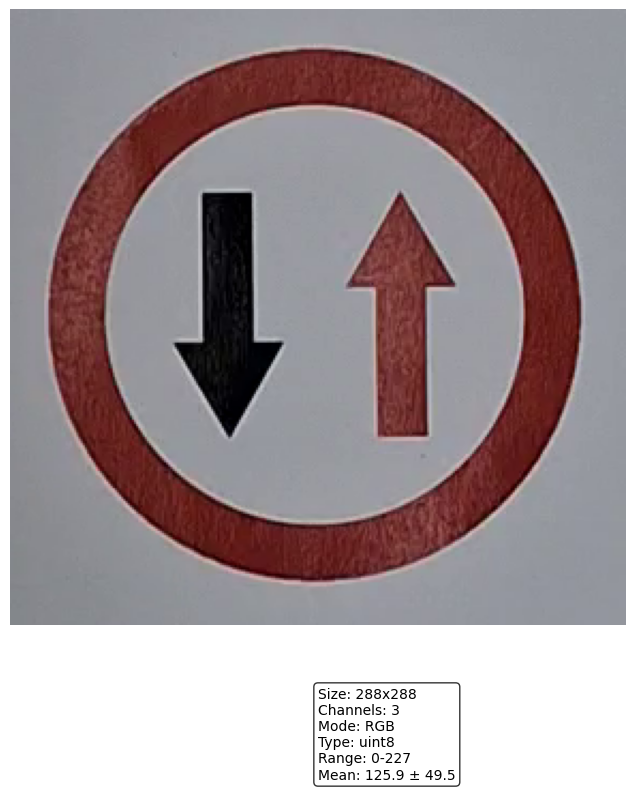


Class: cross_walk
Image: 01_field_00001.png
----------------------------------------
           path: Dataset/Base\cross_walk\01_field_00001.png
       filesize: 308077
  modified_time: 1743702304.389413
         format: PNG
           mode: RGB
           size: (320, 320)
          dtype: uint8
          shape: (320, 320, 3)
       channels: 3
          stats: {'min': np.uint8(0), 'max': np.uint8(241), 'mean': np.float64(103.1676171875), 'std': np.float64(61.14126011403936), 'unique': 242}
            md5: f590f132f5590829b3855360c8c9166c
      has_alpha: False


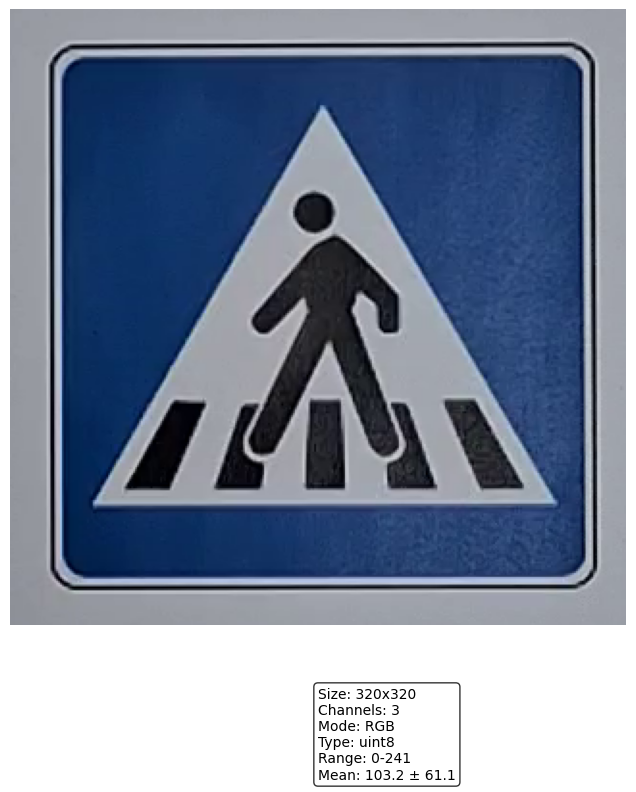


Class: go_straight
Image: 02_field_00001.png
----------------------------------------
           path: Dataset/Base\go_straight\02_field_00001.png
       filesize: 443533
  modified_time: 1743705651.559189
         format: PNG
           mode: RGB
           size: (384, 384)
          dtype: uint8
          shape: (384, 384, 3)
       channels: 3
          stats: {'min': np.uint8(0), 'max': np.uint8(255), 'mean': np.float64(114.3007224754051), 'std': np.float64(59.07481310435806), 'unique': 256}
            md5: 74f235deca8739f9bb0e9fd9e224a064
      has_alpha: False


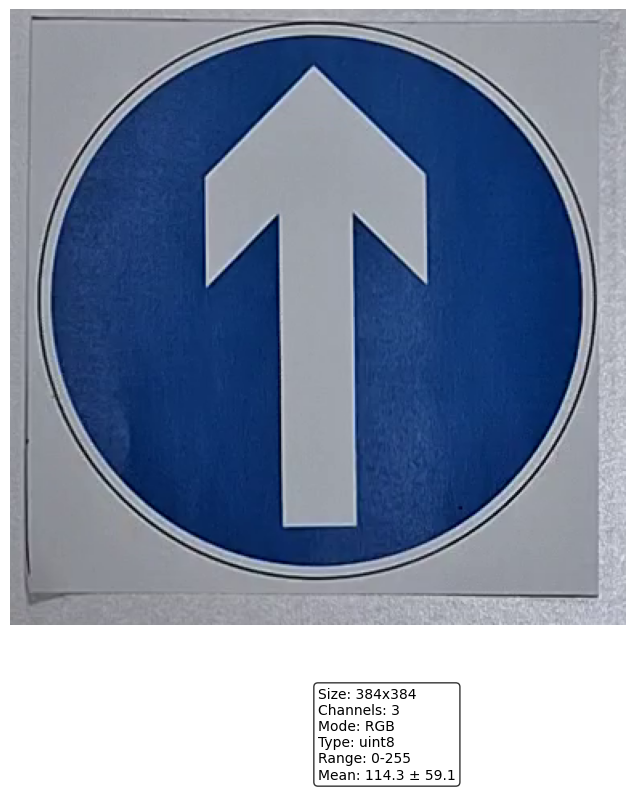


Class: no_passing_zone_beginning
Image: 03_field_00001.png
----------------------------------------
           path: Dataset/Base\no_passing_zone_beginning\03_field_00001.png
       filesize: 443533
  modified_time: 1743706185.2621083
         format: PNG
           mode: RGB
           size: (384, 384)
          dtype: uint8
          shape: (384, 384, 3)
       channels: 3
          stats: {'min': np.uint8(0), 'max': np.uint8(227), 'mean': np.float64(127.31443051938658), 'std': np.float64(46.50128073866891), 'unique': 225}
            md5: e061a6da4277111c9000fbbe07217374
      has_alpha: False


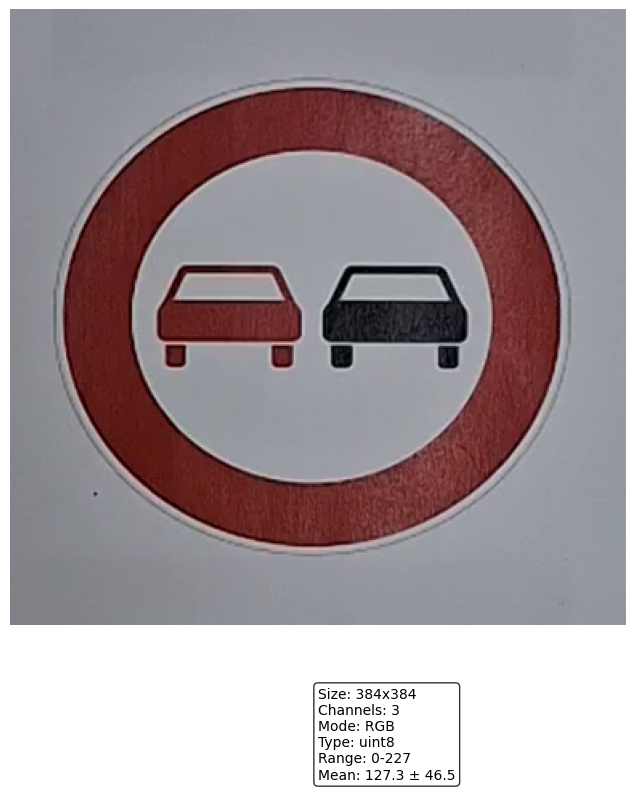


Class: parking_zone
Image: 04_field_00001.png
----------------------------------------
           path: Dataset/Base\parking_zone\04_field_00001.png
       filesize: 692856
  modified_time: 1743706667.3427498
         format: PNG
           mode: RGB
           size: (480, 480)
          dtype: uint8
          shape: (480, 480, 3)
       channels: 3
          stats: {'min': np.uint8(0), 'max': np.uint8(246), 'mean': np.float64(107.73391782407407), 'std': np.float64(60.67045691321321), 'unique': 239}
            md5: dc37d75a2ed0d95079a961fbd23a6cef
      has_alpha: False


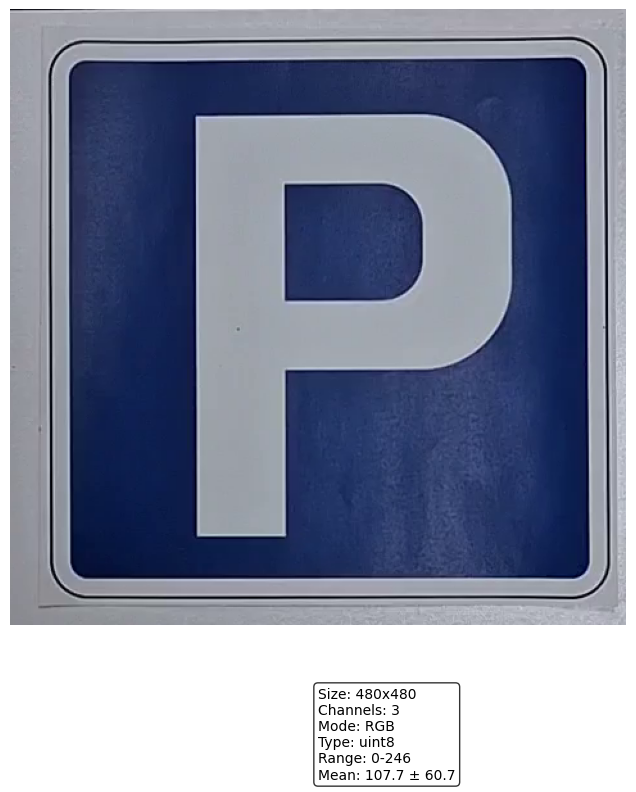


Class: priority_over
Image: 05_field_00001.png
----------------------------------------
           path: Dataset/Base\priority_over\05_field_00001.png
       filesize: 443533
  modified_time: 1743708712.808025
         format: PNG
           mode: RGB
           size: (384, 384)
          dtype: uint8
          shape: (384, 384, 3)
       channels: 3
          stats: {'min': np.uint8(0), 'max': np.uint8(246), 'mean': np.float64(139.76514350043402), 'std': np.float64(40.99920468969122), 'unique': 242}
            md5: cabe2d262cc7b6890fd4f57caa40e81a
      has_alpha: False


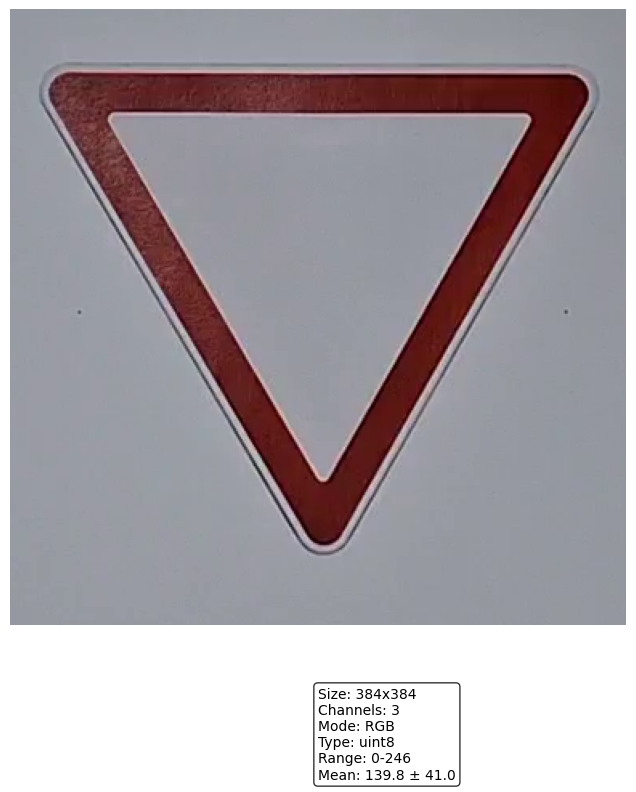


Class: steep_hill_downhill
Image: 06_field_00001.png
----------------------------------------
           path: Dataset/Base\steep_hill_downhill\06_field_00001.png
       filesize: 788279
  modified_time: 1743709317.6754067
         format: PNG
           mode: RGB
           size: (512, 512)
          dtype: uint8
          shape: (512, 512, 3)
       channels: 3
          stats: {'min': np.uint8(0), 'max': np.uint8(248), 'mean': np.float64(126.53110885620117), 'std': np.float64(52.60099532441324), 'unique': 243}
            md5: 73b1c7246d4cfa756200d02ab2f88e31
      has_alpha: False


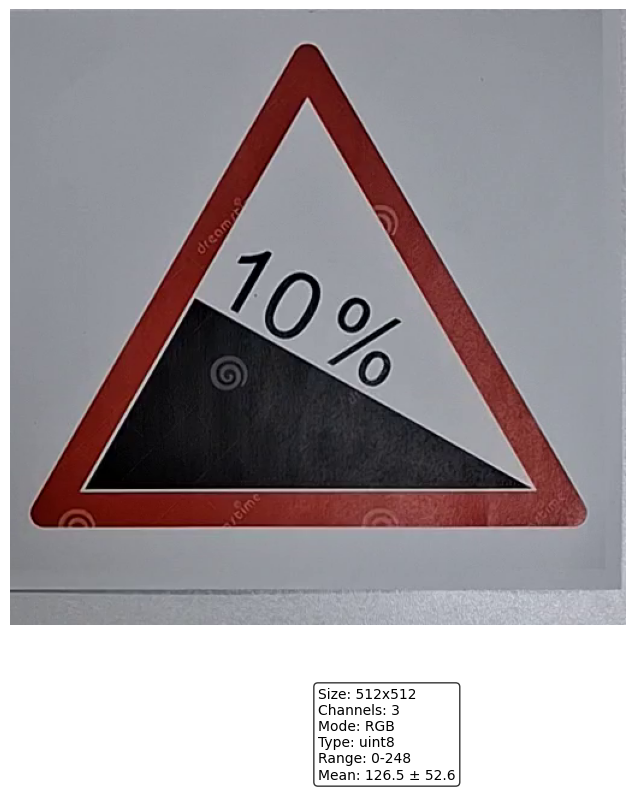


Class: steep_hill_uphill
Image: 07_field_00001.png
----------------------------------------
           path: Dataset/Base\steep_hill_uphill\07_field_00001.png
       filesize: 889841
  modified_time: 1743709969.704283
         format: PNG
           mode: RGB
           size: (544, 544)
          dtype: uint8
          shape: (544, 544, 3)
       channels: 3
          stats: {'min': np.uint8(0), 'max': np.uint8(236), 'mean': np.float64(131.85137214352653), 'std': np.float64(50.42998447036016), 'unique': 227}
            md5: c5a15112524ab4d151dd5b2c386b9b83
      has_alpha: False


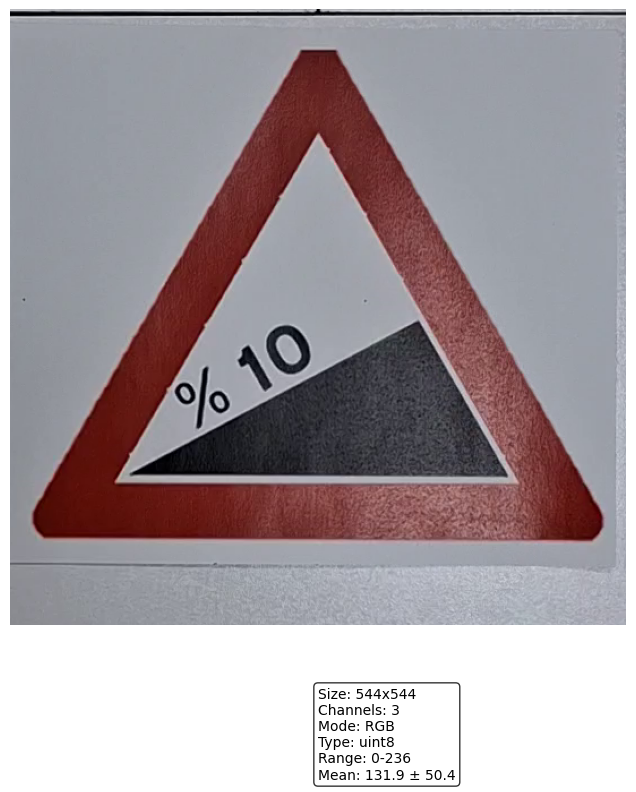


Class: stop
Image: 08_field_00001.png
----------------------------------------
           path: Dataset/Base\stop\08_field_00001.png
       filesize: 788279
  modified_time: 1743710876.9037158
         format: PNG
           mode: RGB
           size: (512, 512)
          dtype: uint8
          shape: (512, 512, 3)
       channels: 3
          stats: {'min': np.uint8(0), 'max': np.uint8(243), 'mean': np.float64(125.23600514729817), 'std': np.float64(46.90797368589247), 'unique': 240}
            md5: c0342d7fc670f730b1c94c9301cf9722
      has_alpha: False


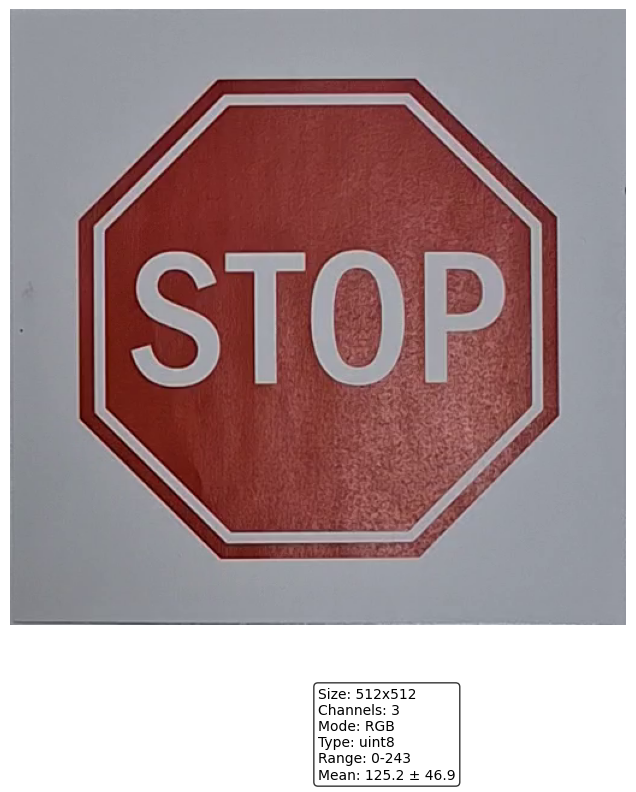


Class: tunnel_beginning
Image: 09_field_00001.png
----------------------------------------
           path: Dataset/Base\tunnel_beginning\09_field_00001.png
       filesize: 603589
  modified_time: 1743712240.8890197
         format: PNG
           mode: RGB
           size: (448, 448)
          dtype: uint8
          shape: (448, 448, 3)
       channels: 3
          stats: {'min': np.uint8(0), 'max': np.uint8(222), 'mean': np.float64(144.7560952115221), 'std': np.float64(34.168405022719924), 'unique': 222}
            md5: 87f9bf717378c0b0361d78c23f7a7984
      has_alpha: False


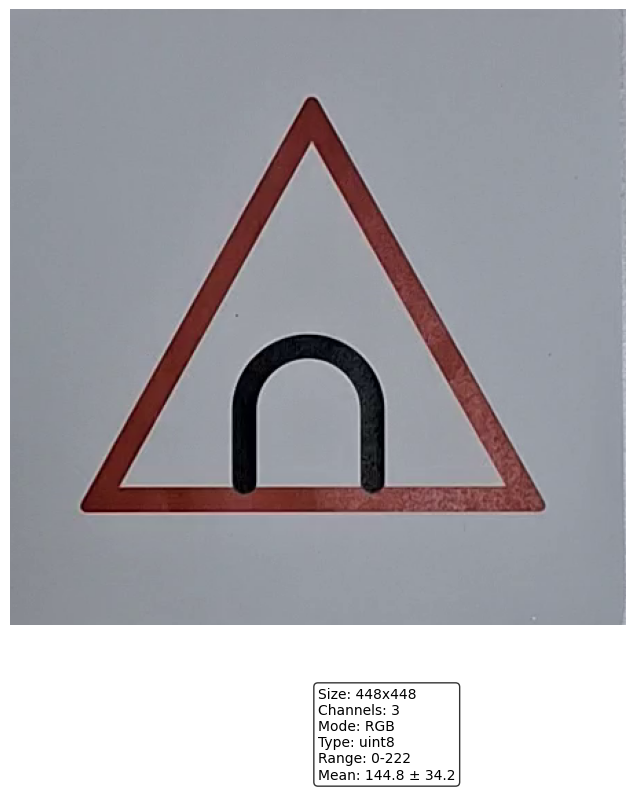


Class: turn_left
Image: 10_field_00001.png
----------------------------------------
           path: Dataset/Base\turn_left\10_field_00001.png
       filesize: 520483
  modified_time: 1743715021.1263309
         format: PNG
           mode: RGB
           size: (416, 416)
          dtype: uint8
          shape: (416, 416, 3)
       channels: 3
          stats: {'min': np.uint8(0), 'max': np.uint8(252), 'mean': np.float64(113.54071129191321), 'std': np.float64(57.46739350779591), 'unique': 249}
            md5: d2b8799debd7e8e45ebda77c52707b0b
      has_alpha: False


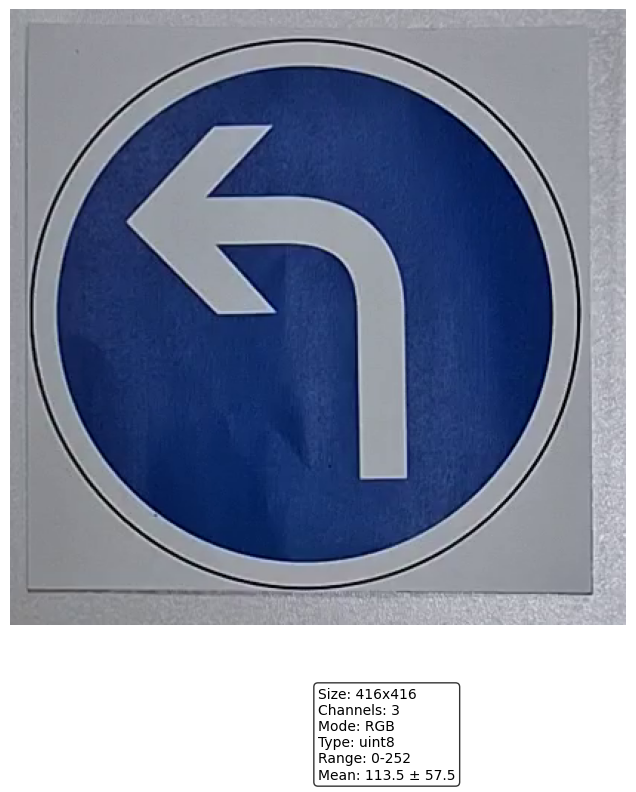


Class: turn_right
Image: 11_field_00001.png
----------------------------------------
           path: Dataset/Base\turn_right\11_field_00001.png
       filesize: 520483
  modified_time: 1743715764.0707116
         format: PNG
           mode: RGB
           size: (416, 416)
          dtype: uint8
          shape: (416, 416, 3)
       channels: 3
          stats: {'min': np.uint8(0), 'max': np.uint8(242), 'mean': np.float64(120.56875616370809), 'std': np.float64(52.765615598929436), 'unique': 239}
            md5: fb1ef36546271d2a84b59a0e15dbbf90
      has_alpha: False


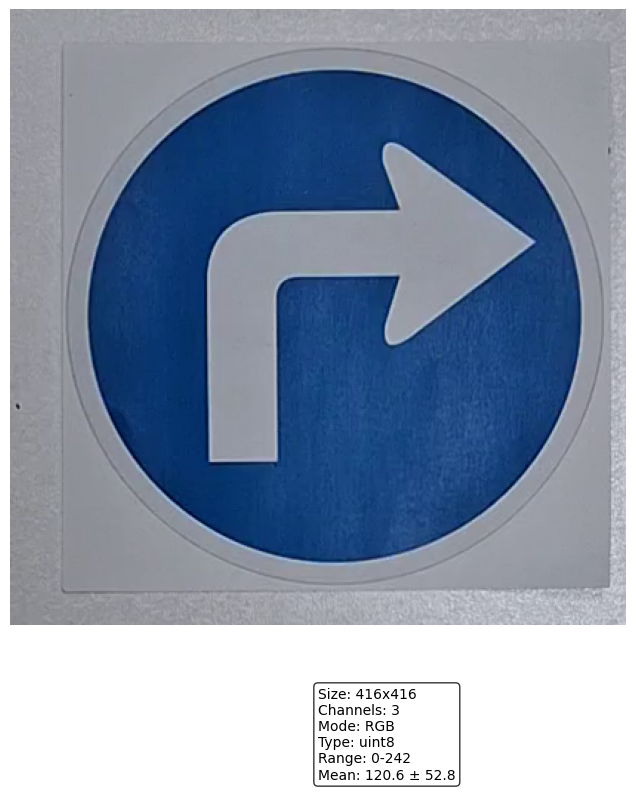

[{'path': 'Dataset/Base\\barred_area\\00_field_00001.png',
  'filesize': 249583,
  'modified_time': 1743700593.7198641,
  'format': 'PNG',
  'mode': 'RGB',
  'size': (288, 288),
  'info': {},
  'dtype': dtype('uint8'),
  'shape': (288, 288, 3),
  'channels': 3,
  'stats': {'min': np.uint8(0),
   'max': np.uint8(227),
   'mean': np.float64(125.87778099279835),
   'std': np.float64(49.46356296666135),
   'unique': 228},
  'md5': '5a623a9173ea1e7402d07a1091bb37c2',
  'has_alpha': False},
 {'path': 'Dataset/Base\\cross_walk\\01_field_00001.png',
  'filesize': 308077,
  'modified_time': 1743702304.389413,
  'format': 'PNG',
  'mode': 'RGB',
  'size': (320, 320),
  'info': {},
  'dtype': dtype('uint8'),
  'shape': (320, 320, 3),
  'channels': 3,
  'stats': {'min': np.uint8(0),
   'max': np.uint8(241),
   'mean': np.float64(103.1676171875),
   'std': np.float64(61.14126011403936),
   'unique': 242},
  'md5': 'f590f132f5590829b3855360c8c9166c',
  'has_alpha': False},
 {'path': 'Dataset/Base\\g

In [5]:
def get_image_analysis(image_path):
    analysis = {}
    
    analysis['path'] = image_path
    analysis['filesize'] = os.path.getsize(image_path)
    analysis['modified_time'] = os.path.getmtime(image_path)
    
    try:
        with Image.open(image_path) as img:
            analysis['format'] = img.format
            analysis['mode'] = img.mode
            analysis['size'] = img.size
            analysis['info'] = img.info
            
        img_cv = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        if img_cv is not None:
            analysis['dtype'] = img_cv.dtype
            analysis['shape'] = img_cv.shape
            analysis['channels'] = img_cv.shape[2] if len(img_cv.shape) > 2 else 1
            
            analysis['stats'] = {
                'min': img_cv.min(),
                'max': img_cv.max(),
                'mean': img_cv.mean(),
                'std': img_cv.std(),
                'unique': len(np.unique(img_cv))
            }
            
            import hashlib
            analysis['md5'] = hashlib.md5(img_cv.tobytes()).hexdigest()
            
            analysis['has_alpha'] = (img_cv.shape[2] == 4) if len(img_cv.shape) > 2 else False
            
        return analysis
    except Exception as e:
        analysis['error'] = str(e)
        return analysis

def visualize_image(analysis):
    img = cv2.imread(analysis['path'])
    if img is None:
        return

    display_text = [
        f"Size: {analysis['size'][0]}x{analysis['size'][1]}",
        f"Channels: {analysis['channels']}",
        f"Mode: {analysis['mode']}",
        f"Type: {analysis['dtype']}",
        f"Range: {analysis['stats']['min']}-{analysis['stats']['max']}",
        f"Mean: {analysis['stats']['mean']:.1f} ± {analysis['stats']['std']:.1f}"
    ]

    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    plt.text(0.5, -0.1, '\n'.join(display_text),
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.axis('off')
    plt.show()

def analyze_dataset(dataset_root, sample_per_folder=1, save_report=False):
    report = []
    
    for root, dirs, files in os.walk(dataset_root):
        if not files:
            continue
            
        image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        samples = image_files[:sample_per_folder]
        
        for img_file in samples:
            img_path = os.path.join(root, img_file)
            analysis = get_image_analysis(img_path)
            report.append(analysis)
            

            print(f"\nClass: {os.path.basename(root)}")
            print(f"Image: {img_file}")
            print("-"*40)
            for k, v in analysis.items():
                if k == 'exif': continue
                if k == 'info': continue
                print(f"{k:>15}: {v}")
                
            if 'error' not in analysis:
                visualize_image(analysis)
            else:
                print(f"Error processing image: {analysis['error']}")
    
    if save_report:
        with open('dataset_analysis_report.txt', 'w') as f:
            for entry in report:
                f.write(f"{'-'*40}\n")
                for k, v in entry.items():
                    f.write(f"{k:>15}: {v}\n")
    
    return report


dataset_path = r"Dataset/Base"
analyze_dataset(dataset_path, sample_per_folder=1)

### Validation

In [6]:
root_dir_val = r'Dataset/Val'
mean, std = calculate_dataset_stats(root_dir_val)

dataset_val_mean = [round(float(m), 5) for m in mean]
dataset_val_std = [round(float(s), 5) for s in std]

print("\nDataset Statistics:")
print("Dataset Mean (RGB):", dataset_val_mean)
print("Dataset Std (RGB):", dataset_val_std)

assert all(0 <= m <= 1 for m in dataset_val_mean), "Mean values out of [0,1] range"
assert all(0 <= s <= 1 for s in dataset_val_std), "Std values out of [0,1] range"

if (abs(mean[0]*255 - 0.485 * 255) < 0.01):
    print("Red mean mismatch")
if (abs(mean[1]*255 - 0.456 * 255) < 0.01):
    print("Green mean mismatch")
if (abs(mean[2]*255 - 0.406 * 255) < 0.01):
    print("Blue mean mismatch")

if (abs(std[0]*255 - 0.229 * 255) < 0.01):
    print("Red std mismatch")
if (abs(std[1]*255 - 0.224 * 255) < 0.01):
    print("Green std mismatch")
if (abs(std[2]*255 - 0.225 * 255) < 0.01):
    print("Blue std mismatch")

print("\nBasic validation checks passed!")

Processing Images: 100%|██████████| 4975/4975 [00:37<00:00, 133.84img/s, Processed=4975, Errors=0, Current=turn_right]               


Validation Summary:
Total images attempted: 4975
Successfully processed: 4975
Problematic files: 0

Dataset Statistics:
Dataset Mean (RGB): [0.58893, 0.58717, 0.61579]
Dataset Std (RGB): [0.23906, 0.24175, 0.21401]

Basic validation checks passed!



Class: barred_area
Image: 00_field_00001.png
----------------------------------------
           path: Dataset/Val\barred_area\00_field_00001.png
       filesize: 49425
  modified_time: 1743980761.136229
         format: PNG
           mode: RGB
           size: (128, 128)
          dtype: uint8
          shape: (128, 128, 3)
       channels: 3
          stats: {'min': np.uint8(27), 'max': np.uint8(217), 'mean': np.float64(168.35237630208334), 'std': np.float64(46.245627441999645), 'unique': 188}
            md5: 30e3edfcacb1a5f2d0c6dc7c575e664d
      has_alpha: False


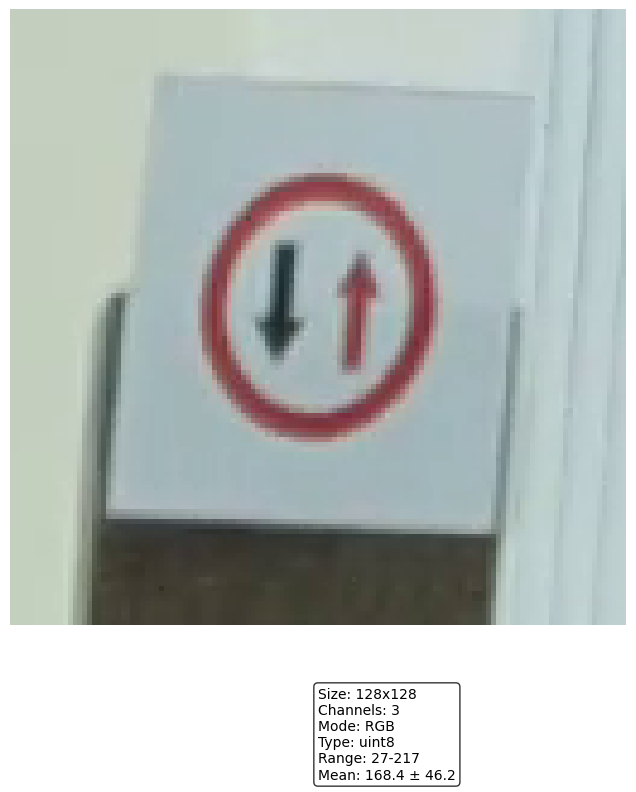


Class: cross_walk
Image: 01_field_00001.png
----------------------------------------
           path: Dataset/Val\cross_walk\01_field_00001.png
       filesize: 49425
  modified_time: 1744013845.503819
         format: PNG
           mode: RGB
           size: (128, 128)
          dtype: uint8
          shape: (128, 128, 3)
       channels: 3
          stats: {'min': np.uint8(18), 'max': np.uint8(219), 'mean': np.float64(159.61861165364584), 'std': np.float64(51.60509968755606), 'unique': 202}
            md5: b33adb0c1025ed2e58d1be146ba0bad3
      has_alpha: False


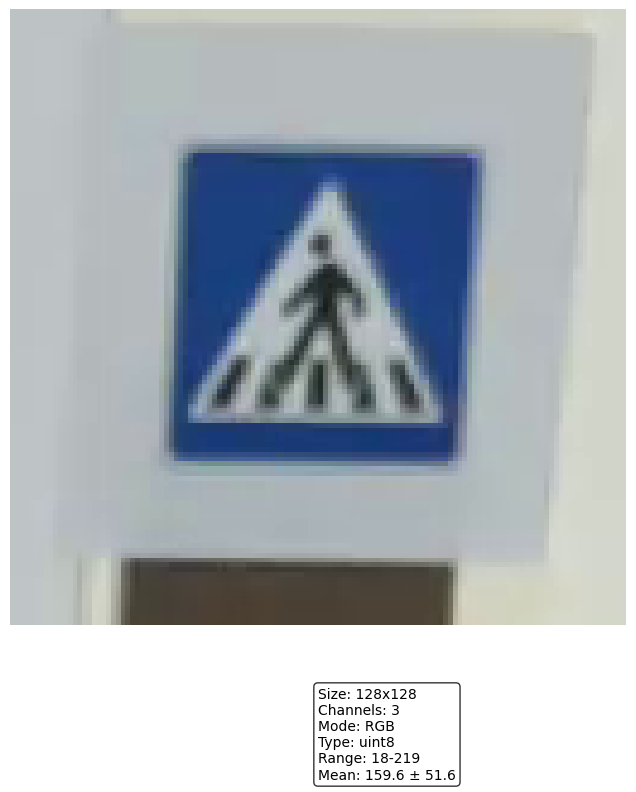


Class: go_straight
Image: 02_field_00001.png
----------------------------------------
           path: Dataset/Val\go_straight\02_field_00001.png
       filesize: 49425
  modified_time: 1744015930.1833613
         format: PNG
           mode: RGB
           size: (128, 128)
          dtype: uint8
          shape: (128, 128, 3)
       channels: 3
          stats: {'min': np.uint8(13), 'max': np.uint8(230), 'mean': np.float64(149.5123494466146), 'std': np.float64(61.94130373109557), 'unique': 210}
            md5: 57ff0ca955780ee8b033222078e0b4c1
      has_alpha: False


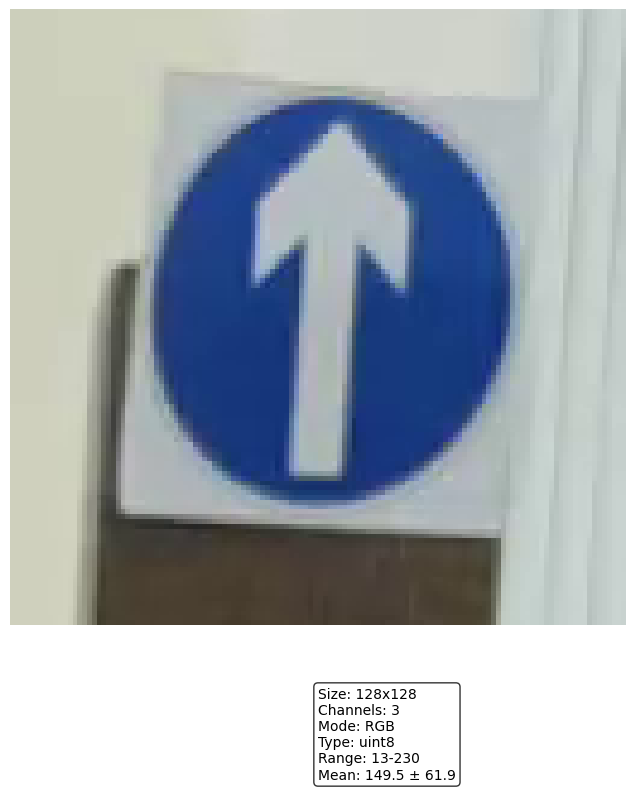


Class: no_passing_zone_beginning
Image: 03_field_00001.png
----------------------------------------
           path: Dataset/Val\no_passing_zone_beginning\03_field_00001.png
       filesize: 49425
  modified_time: 1744018503.4788122
         format: PNG
           mode: RGB
           size: (128, 128)
          dtype: uint8
          shape: (128, 128, 3)
       channels: 3
          stats: {'min': np.uint8(31), 'max': np.uint8(236), 'mean': np.float64(165.21915690104166), 'std': np.float64(52.976609015108785), 'unique': 190}
            md5: a01b5c860bccc6a8d121f2498d6bfa1b
      has_alpha: False


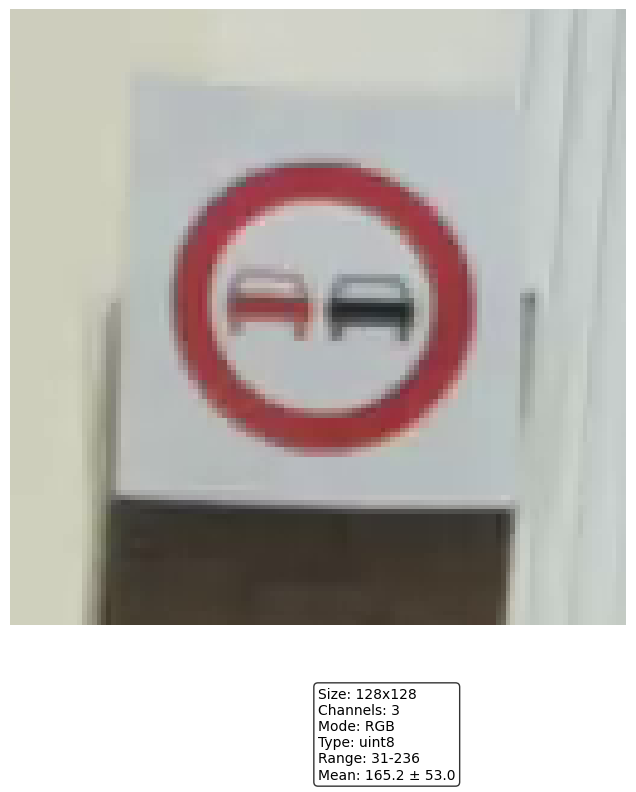


Class: parking_zone
Image: 04_field_00001.png
----------------------------------------
           path: Dataset/Val\parking_zone\04_field_00001.png
       filesize: 49425
  modified_time: 1744129747.399121
         format: PNG
           mode: RGB
           size: (128, 128)
          dtype: uint8
          shape: (128, 128, 3)
       channels: 3
          stats: {'min': np.uint8(22), 'max': np.uint8(217), 'mean': np.float64(133.64349365234375), 'std': np.float64(63.89500110146828), 'unique': 196}
            md5: 3102f02674c0cfbffe2143c599e58dd7
      has_alpha: False


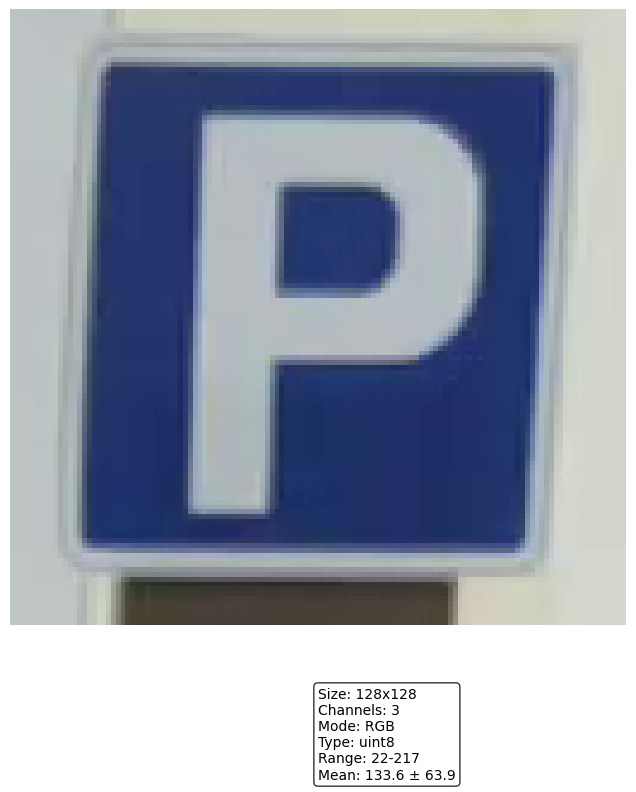


Class: priority_over
Image: 05_field_00001.png
----------------------------------------
           path: Dataset/Val\priority_over\05_field_00001.png
       filesize: 49425
  modified_time: 1744131453.2131364
         format: PNG
           mode: RGB
           size: (128, 128)
          dtype: uint8
          shape: (128, 128, 3)
       channels: 3
          stats: {'min': np.uint8(34), 'max': np.uint8(239), 'mean': np.float64(185.3064168294271), 'std': np.float64(36.23852695823805), 'unique': 202}
            md5: d02e765556f3cd9faf1e9c24996e337b
      has_alpha: False


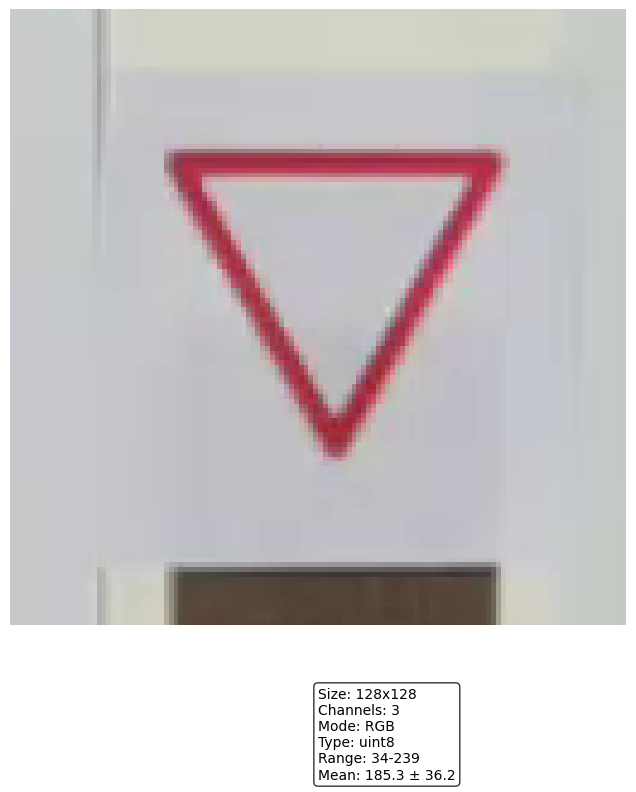


Class: steep_hill_downhill
Image: 06_field_00001.png
----------------------------------------
           path: Dataset/Val\steep_hill_downhill\06_field_00001.png
       filesize: 49425
  modified_time: 1744136712.185388
         format: PNG
           mode: RGB
           size: (128, 128)
          dtype: uint8
          shape: (128, 128, 3)
       channels: 3
          stats: {'min': np.uint8(22), 'max': np.uint8(225), 'mean': np.float64(158.20540364583334), 'std': np.float64(53.681622917856004), 'unique': 194}
            md5: 6609070fc5544ac25f1a15a6add982a3
      has_alpha: False


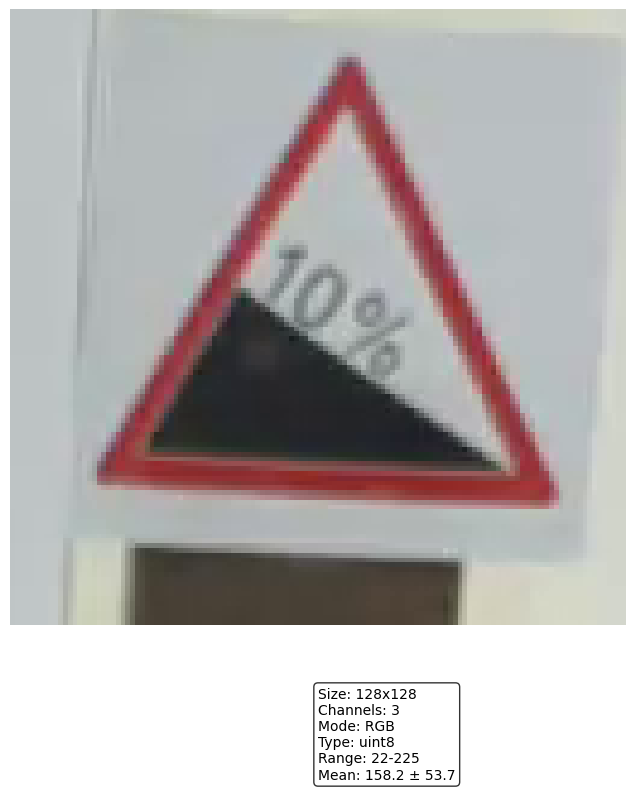


Class: steep_hill_uphill
Image: 07_field_00001.png
----------------------------------------
           path: Dataset/Val\steep_hill_uphill\07_field_00001.png
       filesize: 49425
  modified_time: 1744137707.3228078
         format: PNG
           mode: RGB
           size: (128, 128)
          dtype: uint8
          shape: (128, 128, 3)
       channels: 3
          stats: {'min': np.uint8(20), 'max': np.uint8(228), 'mean': np.float64(153.0457560221354), 'std': np.float64(56.30782728057987), 'unique': 203}
            md5: 42c8734a943bd4c04a211fabb0bec7b1
      has_alpha: False


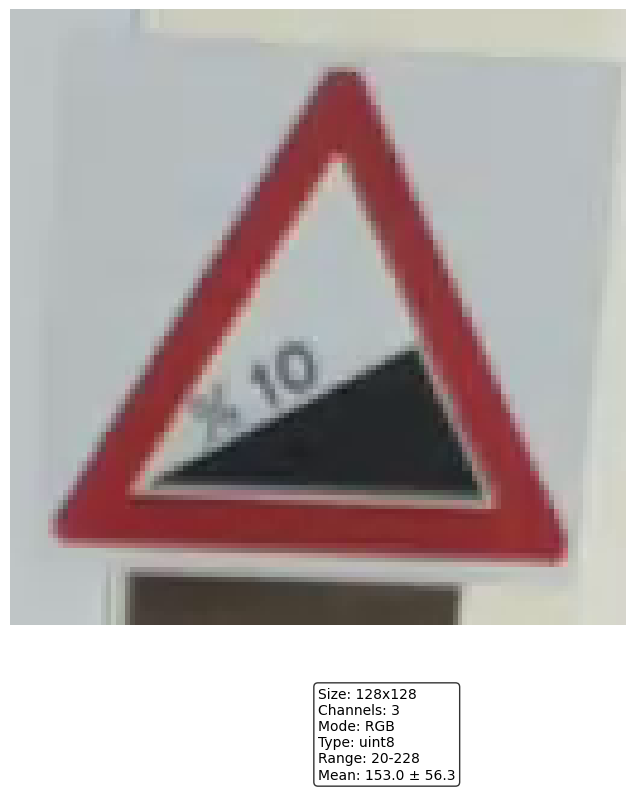


Class: stop
Image: 08_field_00001.png
----------------------------------------
           path: Dataset/Val\stop\08_field_00001.png
       filesize: 49425
  modified_time: 1744138706.5105934
         format: PNG
           mode: RGB
           size: (128, 128)
          dtype: uint8
          shape: (128, 128, 3)
       channels: 3
          stats: {'min': np.uint8(44), 'max': np.uint8(229), 'mean': np.float64(159.53961181640625), 'std': np.float64(50.205150599558145), 'unique': 178}
            md5: 780bcd4cd7f176ef3f957fa530d0782c
      has_alpha: False


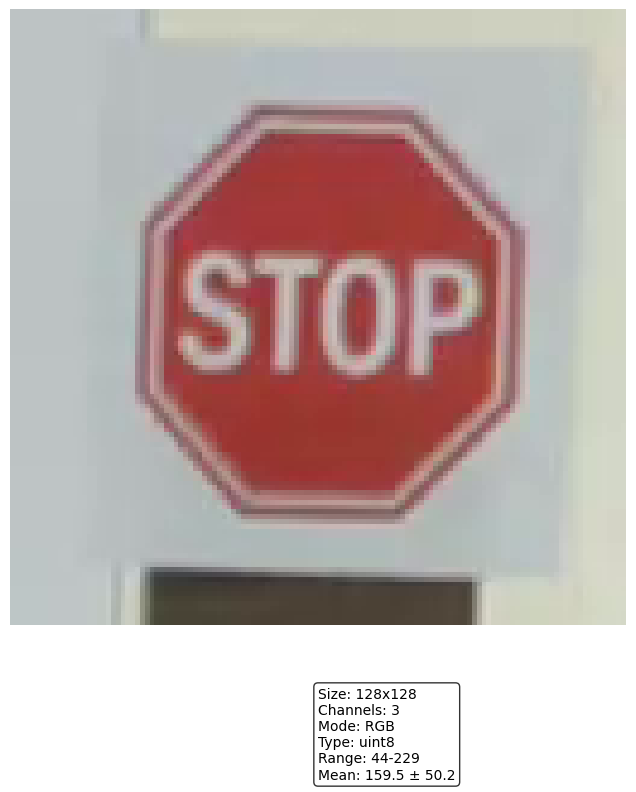


Class: tunnel_beginning
Image: 09_field_00001.png
----------------------------------------
           path: Dataset/Val\tunnel_beginning\09_field_00001.png
       filesize: 49425
  modified_time: 1744144287.9692936
         format: PNG
           mode: RGB
           size: (128, 128)
          dtype: uint8
          shape: (128, 128, 3)
       channels: 3
          stats: {'min': np.uint8(34), 'max': np.uint8(218), 'mean': np.float64(178.34615071614584), 'std': np.float64(31.183009769768912), 'unique': 185}
            md5: e4e3a594bec97a3e0e130f5937db88ab
      has_alpha: False


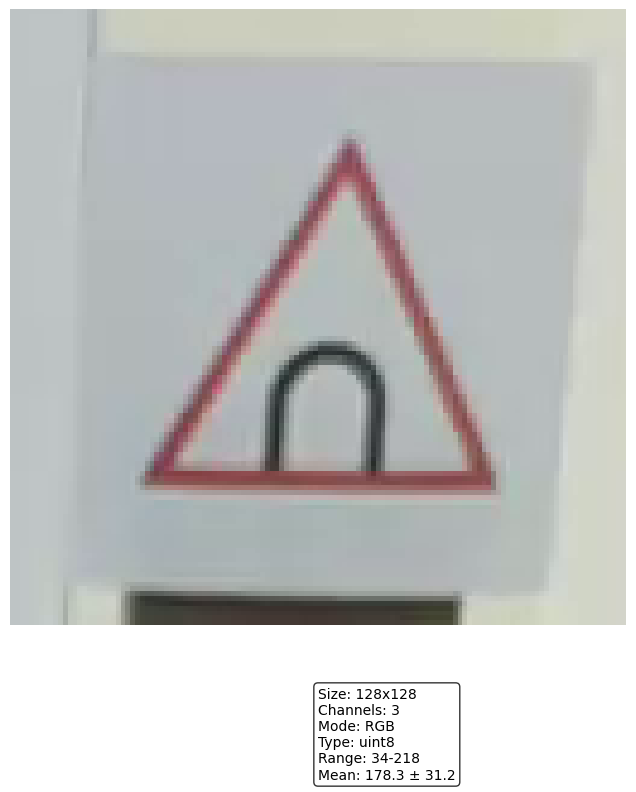


Class: turn_left
Image: 10_field_00001.png
----------------------------------------
           path: Dataset/Val\turn_left\10_field_00001.png
       filesize: 49425
  modified_time: 1744145765.596869
         format: PNG
           mode: RGB
           size: (128, 128)
          dtype: uint8
          shape: (128, 128, 3)
       channels: 3
          stats: {'min': np.uint8(15), 'max': np.uint8(224), 'mean': np.float64(156.04654947916666), 'std': np.float64(59.94309528493418), 'unique': 202}
            md5: 024aff9602ec347c20732e71b11e181d
      has_alpha: False


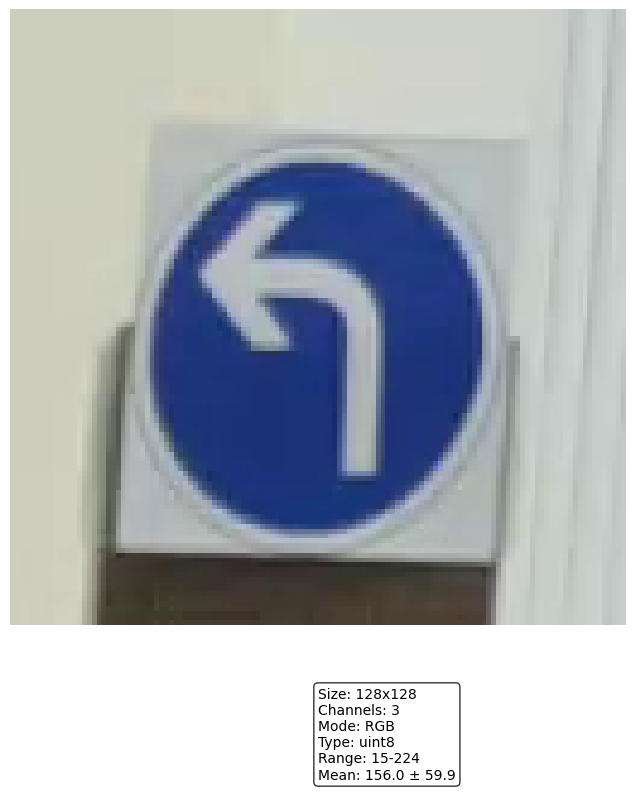


Class: turn_right
Image: 11_field_00001.png
----------------------------------------
           path: Dataset/Val\turn_right\11_field_00001.png
       filesize: 49425
  modified_time: 1744146965.1412673
         format: PNG
           mode: RGB
           size: (128, 128)
          dtype: uint8
          shape: (128, 128, 3)
       channels: 3
          stats: {'min': np.uint8(9), 'max': np.uint8(221), 'mean': np.float64(150.1248575846354), 'std': np.float64(60.83088676358611), 'unique': 209}
            md5: 804e1be6fefdf18ffad175aecde07ef6
      has_alpha: False


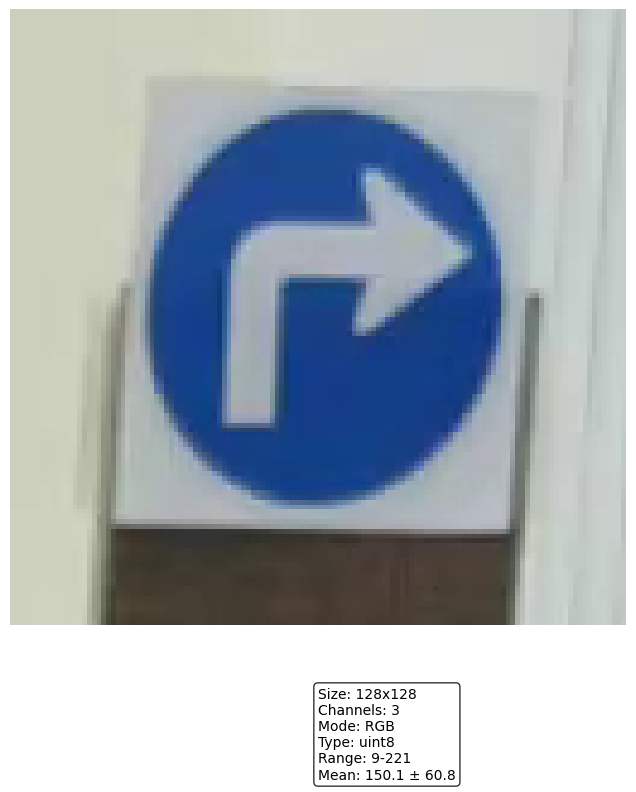

[{'path': 'Dataset/Val\\barred_area\\00_field_00001.png',
  'filesize': 49425,
  'modified_time': 1743980761.136229,
  'format': 'PNG',
  'mode': 'RGB',
  'size': (128, 128),
  'info': {},
  'dtype': dtype('uint8'),
  'shape': (128, 128, 3),
  'channels': 3,
  'stats': {'min': np.uint8(27),
   'max': np.uint8(217),
   'mean': np.float64(168.35237630208334),
   'std': np.float64(46.245627441999645),
   'unique': 188},
  'md5': '30e3edfcacb1a5f2d0c6dc7c575e664d',
  'has_alpha': False},
 {'path': 'Dataset/Val\\cross_walk\\01_field_00001.png',
  'filesize': 49425,
  'modified_time': 1744013845.503819,
  'format': 'PNG',
  'mode': 'RGB',
  'size': (128, 128),
  'info': {},
  'dtype': dtype('uint8'),
  'shape': (128, 128, 3),
  'channels': 3,
  'stats': {'min': np.uint8(18),
   'max': np.uint8(219),
   'mean': np.float64(159.61861165364584),
   'std': np.float64(51.60509968755606),
   'unique': 202},
  'md5': 'b33adb0c1025ed2e58d1be146ba0bad3',
  'has_alpha': False},
 {'path': 'Dataset/Val\\

In [7]:
def get_image_analysis(image_path):
    analysis = {}
    
    analysis['path'] = image_path
    analysis['filesize'] = os.path.getsize(image_path)
    analysis['modified_time'] = os.path.getmtime(image_path)
    
    try:
        with Image.open(image_path) as img:
            analysis['format'] = img.format
            analysis['mode'] = img.mode
            analysis['size'] = img.size
            analysis['info'] = img.info
            
        img_cv = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
        if img_cv is not None:
            analysis['dtype'] = img_cv.dtype
            analysis['shape'] = img_cv.shape
            analysis['channels'] = img_cv.shape[2] if len(img_cv.shape) > 2 else 1
            
            analysis['stats'] = {
                'min': img_cv.min(),
                'max': img_cv.max(),
                'mean': img_cv.mean(),
                'std': img_cv.std(),
                'unique': len(np.unique(img_cv))
            }
            
            import hashlib
            analysis['md5'] = hashlib.md5(img_cv.tobytes()).hexdigest()
            
            analysis['has_alpha'] = (img_cv.shape[2] == 4) if len(img_cv.shape) > 2 else False
            
        return analysis
    except Exception as e:
        analysis['error'] = str(e)
        return analysis

def visualize_image(analysis):
    img = cv2.imread(analysis['path'])
    if img is None:
        return

    display_text = [
        f"Size: {analysis['size'][0]}x{analysis['size'][1]}",
        f"Channels: {analysis['channels']}",
        f"Mode: {analysis['mode']}",
        f"Type: {analysis['dtype']}",
        f"Range: {analysis['stats']['min']}-{analysis['stats']['max']}",
        f"Mean: {analysis['stats']['mean']:.1f} ± {analysis['stats']['std']:.1f}"
    ]

    plt.figure(figsize=(12, 8))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    plt.text(0.5, -0.1, '\n'.join(display_text),
             transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.axis('off')
    plt.show()

def analyze_dataset(dataset_root, sample_per_folder=1, save_report=False):
    report = []
    
    for root, dirs, files in os.walk(dataset_root):
        if not files:
            continue
            
        image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        samples = image_files[:sample_per_folder]
        
        for img_file in samples:
            img_path = os.path.join(root, img_file)
            analysis = get_image_analysis(img_path)
            report.append(analysis)
            

            print(f"\nClass: {os.path.basename(root)}")
            print(f"Image: {img_file}")
            print("-"*40)
            for k, v in analysis.items():
                if k == 'exif': continue
                if k == 'info': continue
                print(f"{k:>15}: {v}")
                
            if 'error' not in analysis:
                visualize_image(analysis)
            else:
                print(f"Error processing image: {analysis['error']}")
    
    if save_report:
        with open('dataset_analysis_report.txt', 'w') as f:
            for entry in report:
                f.write(f"{'-'*40}\n")
                for k, v in entry.items():
                    f.write(f"{k:>15}: {v}\n")
    
    return report


dataset_path = r"Dataset/Val"
analyze_dataset(dataset_path, sample_per_folder=1)

## Data Augmentation

In [24]:
dataset_base_mean = [0.48011, 0.47254, 0.52592]
dataset_base_std = [0.20765, 0.21533, 0.20043]

dataset_val_mean = [0.58893, 0.58717, 0.61579]
dataset_val_std = [0.23906, 0.24175, 0.21401]

img_size = 32

In [25]:
transform_album = A.Compose([
        A.Resize(32, 32),
        # A.LongestMaxSize(max_size=32, interpolation=cv2.INTER_LINEAR, p=1.0),
        # A.PadIfNeeded(
        #     min_height=32,
        #     min_width=32,
        #     border_mode=cv2.BORDER_CONSTANT,
        #     p=1.0),
        A.Affine(
            scale=(0.95, 1.05),
            shear=(-5, 5),
            fill=0,
            p=0.7),
        A.Perspective(
            scale=(0.05, 0.1),
            keep_size=True,
            interpolation=cv2.INTER_LINEAR,
            border_mode=cv2.BORDER_CONSTANT,
            fill=0,
            p=0.5),
        A.RandomBrightnessContrast(
            brightness_limit=(-0.5, 0.5),
            contrast_limit=(-0.2, 0.2),
            p=0.8),
        A.RGBShift(
            r_shift_limit=(-10, 10),
            g_shift_limit=(-10, 10),
            b_shift_limit=(-10, 10),
            p=0.8),
        A.MotionBlur(
            blur_limit=(5, 7),
            p=0.3),
        A.GaussNoise(
            std_range=(0.01, 0.02),
            p=0.3),
        A.Normalize(
            mean=tuple(dataset_base_mean),
            std=tuple(dataset_base_std),
            max_pixel_value=255.0,
            normalization="standard",
            p=1.0),
        ToTensorV2(p=1.0)
    ])

In [26]:
transform_simple_base = A.Compose([
        A.Resize(32, 32),
        A.Normalize(
            mean=tuple(dataset_base_mean),
            std=tuple(dataset_base_std),
            max_pixel_value=255.0,
            normalization="standard",
            p=1.0),
        ToTensorV2(p=1.0)
    ])

transform_simple_val = A.Compose([
        A.Resize(32, 32),
        A.Normalize(
            mean=tuple(dataset_val_mean),
            std=tuple(dataset_val_std),
            max_pixel_value=255.0,
            normalization="standard",
            p=1.0),
        ToTensorV2(p=1.0)
    ])

In [27]:
transform_resize = A.Compose([
        A.Resize(32, 32),
        ToTensorV2(p=1.0)
    ])

In [ ]:
root_dir_dataset = r'Dataset/Base'
root_dir_augmented = r'Dataset/Augmented'
root_dir_val = r'Dataset/Val'
os.makedirs(root_dir_augmented, exist_ok=True)

images_path_list = []
labels_path_list = []
class_idx = {}
augmentation_count = 5

class_names = sorted([d for d in os.listdir(root_dir_dataset)
                      if os.path.isdir(os.path.join(root_dir_dataset, d))])

for cls_idx, class_name in enumerate(class_names):
    class_idx[cls_idx] = class_name
    images_tmp = os.path.join(root_dir_dataset, class_name, "*.png")
    images_paths = glob.glob(images_tmp)
    
    for img_path in images_paths:
        images_path_list.append(img_path)
        labels_path_list.append(cls_idx)

### Augmented Images

In [32]:
pbar = tqdm(total=len(images_path_list) * augmentation_count, 
            desc="Augmenting Images", 
            unit="img", 
            dynamic_ncols=True)

for class_name in class_names:
    class_dir = os.path.join(root_dir_augmented, class_name)
    os.makedirs(class_dir, exist_ok=True)
    
    if not os.path.exists(class_dir):
        raise RuntimeError(f"Failed to create directory: {class_dir}")

for img_path in images_path_list:
    class_name = os.path.basename(os.path.dirname(img_path))
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read image {img_path}")
        pbar.update(augmentation_count)
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    
    for aug_num in range(1, augmentation_count + 1):
        transformed = transform_album(image=img)
        transformed_img = transformed['image']
        
        transformed_img = transformed_img.permute(1, 2, 0).numpy()
        transformed_img = (transformed_img * np.array(dataset_base_std) + np.array(dataset_base_mean))
        transformed_img = np.clip(transformed_img * 255, 0, 255).astype(np.uint8)
        
        new_filename = f"{base_name}_aug_{aug_num:02d}.png"
        new_path = os.path.join(root_dir_augmented, class_name, new_filename)
        
        if not os.path.exists(os.path.dirname(new_path)):
            os.makedirs(os.path.dirname(new_path), exist_ok=True)
        
        try:
            save_success = cv2.imwrite(new_path, cv2.cvtColor(transformed_img, cv2.COLOR_RGB2BGR))
            if not save_success:
                Image.fromarray(transformed_img).save(new_path)
                print(f"Used PIL fallback for {new_path}")
        except Exception as save_error:
            print(f"Failed to save {new_path}: {str(save_error)}")
            continue
        
        pbar.update(1)
        pbar.set_postfix_str(f"Processing: {class_name}/{new_filename}")

pbar.close()
output_files = glob.glob(os.path.join(root_dir_augmented, "**", "*.png"), recursive=True)
print(f"\nAugmentation complete. {len(images_path_list)} → {len(images_path_list)*augmentation_count} files")
print(f"Augmented images saved in: {os.path.abspath(root_dir_augmented)}")

Augmenting Images: 100%|██████████| 32540/32540 [02:27<00:00, 220.31img/s, Processing: turn_right/11_field_00555_aug_05.png]



Augmentation complete. 6508 → 32540 files
Augmented images saved in: c:\Users\tahaa\Documents\PythonProjects\MachineLearning\IKIUSelfDrivingCar\Dataset\Augmented


### Normalized Base

In [33]:
images_path_list = []
for class_name in os.listdir(root_dir_dataset):
    class_path = os.path.join(root_dir_dataset, class_name)
    if os.path.isdir(class_path):
        images_path_list.extend(glob.glob(os.path.join(class_path, "*.png")))

pbar = tqdm(total=len(images_path_list), 
           desc="Processing Images", 
           unit="img", 
           dynamic_ncols=True)

for img_path in images_path_list:
    try:
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        
        transformed = transform_simple_base(image=img)
        processed_img = transformed['image']
        
        processed_img = processed_img.permute(1, 2, 0).numpy()
        processed_img = (processed_img * dataset_base_std + dataset_base_mean) * 255
        processed_img = processed_img.clip(0, 255).astype(np.uint8)
        
        cv2.imwrite(img_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))
        pbar.update(1)
        
    except Exception as e:
        print(f"\nError processing {img_path}: {str(e)}")
        continue

pbar.close()
print(f"\nProcessing complete. {len(images_path_list)} images replaced")
print(f"Original images overwritten in: {os.path.abspath(root_dir_dataset)}")

Processing Images: 100%|██████████| 6508/6508 [00:15<00:00, 432.21img/s]


Processing complete. 6508 images replaced
Original images overwritten in: c:\Users\tahaa\Documents\PythonProjects\MachineLearning\IKIUSelfDrivingCar\Dataset\Base


### Normalized Val

In [34]:
images_path_list = []
for class_name in os.listdir(root_dir_val):
    class_path = os.path.join(root_dir_val, class_name)
    if os.path.isdir(class_path):
        images_path_list.extend(glob.glob(os.path.join(class_path, "*.png")))

pbar = tqdm(total=len(images_path_list), 
           desc="Processing Images", 
           unit="img", 
           dynamic_ncols=True)

for img_path in images_path_list:
    try:
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        
        transformed = transform_simple_val(image=img)
        processed_img = transformed['image']
        
        processed_img = processed_img.permute(1, 2, 0).numpy()
        processed_img = (processed_img * dataset_val_std + dataset_val_mean) * 255
        processed_img = processed_img.clip(0, 255).astype(np.uint8)
        
        cv2.imwrite(img_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))
        pbar.update(1)
        
    except Exception as e:
        print(f"\nError processing {img_path}: {str(e)}")
        continue

pbar.close()
print(f"\nProcessing complete. {len(images_path_list)} images replaced")
print(f"Original images overwritten in: {os.path.abspath(root_dir_val)}")

Processing Images: 100%|██████████| 4975/4975 [00:06<00:00, 741.51img/s]


Processing complete. 4975 images replaced
Original images overwritten in: c:\Users\tahaa\Documents\PythonProjects\MachineLearning\IKIUSelfDrivingCar\Dataset\Val


## Dataset Class

In [2]:
class TrafficSignDB(Dataset):
    def __init__(self, images_path_list, labels_path_list, transform=None):
        self.images_path_list = images_path_list
        self.labels_path_list = labels_path_list
        self.transform = transform
        self.class_names = sorted(list(set(os.path.basename(os.path.dirname(p)) for p in images_path_list)))
        self.idx_to_class = self._create_label_mapping()
        
    def _create_label_mapping(self):
        return {idx: name for idx, name in enumerate(class_names)}
    
    def __len__(self):
        return len(self.images_path_list)
    
    def __getitem__(self, index):
        path = self.images_path_list[index]
        label = self.labels_path_list[index]
        
        try:
            import cv2
            image = cv2.imread(path)
            if image is None:
                raise ValueError("Image could not be read")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            if self.transform:
                if isinstance(self.transform, A.Compose):
                    # Albumentations Pipeline
                    augmented = self.transform(image=image)
                    image = augmented["image"]
                else:
                    # PyTorch PIL
                    from PIL import Image
                    image = Image.open(path).convert("RGB")
                    image = self.transform(image)
            else:
                from albumentations.pytorch import ToTensorV2
                image = ToTensorV2()(image=image)["image"]
            
        except Exception as e:
            print(f"Error processing image {path}: {e}")
            image = torch.zeros(3, 32, 32)
            
        return image, label
    
    def get_class_name(self, label_idx):
        return self.idx_to_class.get(label_idx, "unknown")

In [3]:
class TrafficSignDBNPY(Dataset):
    def __init__(self, X_npy_path, y_npy_path, transform=None):
        if isinstance(X_npy_path, (str, bytes, os.PathLike)):
            self.X = np.load(X_npy_path)
        else:
            self.X = X_npy_path

        if isinstance(y_npy_path, (str, bytes, os.PathLike)):
            self.y = np.load(y_npy_path)
        else:
            self.y = y_npy_path
            
        self.transform = transform
        self.y_int = np.argmax(self.y, axis=1)
        
        self.class_names = [
            'barred_area',
            'cross_walk',
            'go_straight',
            'no_passing_zone_beginning',
            'parking_zone',
            'priority_over',
            'steep_hill_downhill',
            'steep_hill_uphill',
            'stop',
            'tunnel_beginning',
            'turn_left',
            'turn_right'
        ]
        self.idx_to_class = self._create_label_mapping()

    def _create_label_mapping(self):
        return {idx: name for idx, name in enumerate(class_names)}
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        path = self.X[index]
        label = int(self.y_int[index])
        
        if self.transform:
            image = path.transpose(1, 2, 0)
            transformed = self.transform(image=image)
            image = transformed["image"]
        else:
            image = torch.from_numpy(path)
        
        return image, label
    
    def get_class_name(self, label_idx):
        return self.class_names[label_idx] if label_idx < len(self.class_names) else "unknown"

## Train/Test List and NPY

In [13]:
img_size = 32

root_dir = r'Dataset'
root_dir_dataset = r'Dataset/Base'
root_dir_augmented = r'Dataset/Augmented'
root_dir_val = r'Dataset/Val'

images_path_list_train = []
labels_path_list_train = []

images_path_list_test = []
labels_path_list_test = []

images_path_list_val = []
labels_path_list_val = []

class_idx = {}

class_names = sorted([d for d in os.listdir(root_dir_dataset)
                      if os.path.isdir(os.path.join(root_dir_dataset, d))])

for cls_idx, class_name in enumerate(class_names):
    class_idx[cls_idx] = class_name
    
    # Augmented images (train)
    aug_pattern = os.path.join(root_dir_augmented, class_name, "*.png")
    aug_images_paths = glob.glob(aug_pattern)
    np.random.shuffle(aug_images_paths)
    for aug_path in aug_images_paths:
        images_path_list_train.append(aug_path)
        labels_path_list_train.append(cls_idx)

    # Dataset images (test)
    base_pattern = os.path.join(root_dir_dataset, class_name, "*.png")
    base_images_paths = glob.glob(base_pattern)
    np.random.shuffle(base_images_paths)
    for test_path in base_images_paths:
        images_path_list_test.append(test_path)
        labels_path_list_test.append(cls_idx)
    
    # Validation images (val)
    val_pattern = os.path.join(root_dir_val, class_name, "*.png")
    val_images_paths = glob.glob(val_pattern)
    np.random.shuffle(val_images_paths)
    for val_path in val_images_paths:
        images_path_list_val.append(val_path)
        labels_path_list_val.append(cls_idx)

In [14]:
total_train = len(images_path_list_train)
total_test = len(images_path_list_test)
total_val = len(images_path_list_val)
total_all = total_train + total_val + total_test

perc_train = total_train / total_all * 100
perc_test = total_test / total_all * 100
perc_val = total_val / total_all * 100

print("Final dataset sizes:")
print(f"Training: {total_train} samples ({perc_train:.2f}%)")
print(f"Testing: {total_test} samples ({perc_test:.2f}%)")
print(f"Validation: {total_val} samples ({perc_val:.2f}%)")

train_counts = Counter(labels_path_list_train)
test_counts = Counter(labels_path_list_test)
val_counts = Counter(labels_path_list_val)

print("\nTraining Class Distribution:")
for idx in sorted(train_counts.keys()):
    print(f"Class '{class_idx[idx]}' (Index {idx}): {train_counts[idx]} samples")

print("\nTesting Class Distribution:")
for idx in sorted(test_counts.keys()):
    print(f"Class '{class_idx[idx]}' (Index {idx}): {test_counts[idx]} samples")

print("\nValidation Class Distribution:")
for idx in sorted(val_counts.keys()):
    print(f"Class '{class_idx[idx]}' (Index {idx}): {val_counts[idx]} samples")

Final dataset sizes:
Training: 32540 samples (73.92%)
Testing: 6508 samples (14.78%)
Validation: 4975 samples (11.30%)

Training Class Distribution:
Class 'barred_area' (Index 0): 3085 samples
Class 'cross_walk' (Index 1): 2905 samples
Class 'go_straight' (Index 2): 2485 samples
Class 'no_passing_zone_beginning' (Index 3): 2825 samples
Class 'parking_zone' (Index 4): 2415 samples
Class 'priority_over' (Index 5): 2880 samples
Class 'steep_hill_downhill' (Index 6): 2135 samples
Class 'steep_hill_uphill' (Index 7): 2395 samples
Class 'stop' (Index 8): 2730 samples
Class 'tunnel_beginning' (Index 9): 3010 samples
Class 'turn_left' (Index 10): 2900 samples
Class 'turn_right' (Index 11): 2775 samples

Testing Class Distribution:
Class 'barred_area' (Index 0): 617 samples
Class 'cross_walk' (Index 1): 581 samples
Class 'go_straight' (Index 2): 497 samples
Class 'no_passing_zone_beginning' (Index 3): 565 samples
Class 'parking_zone' (Index 4): 483 samples
Class 'priority_over' (Index 5): 576 s

In [15]:
if ('images_path_list_train' in globals() and 
    'images_path_list_val' in globals() and 
    'images_path_list_test' in globals()):
    
    train_files = set(images_path_list_train)
    val_files = set(images_path_list_val)
    test_files = set(images_path_list_test)
    
    dup_train_val = train_files.intersection(val_files)
    dup_train_test = train_files.intersection(test_files)
    dup_val_test = val_files.intersection(test_files)
    
    print("Duplicates between training and validation:", len(dup_train_val))
    print("Duplicates between training and test:", len(dup_train_test))
    print("Duplicates between validation and test:", len(dup_val_test))
else:
    print("File path lists not found; skipping duplicate check.")

Duplicates between training and validation: 0
Duplicates between training and test: 0
Duplicates between validation and test: 0


In [16]:
def one_hot_encoder(labels, num_classes):
    encoded = np.zeros((len(labels), num_classes), dtype=np.float32)
    encoded[np.arange(len(labels)), labels] = 1.0
    return encoded

In [17]:
def process_img_npy(image_paths, labels, save_dir, dataset_type, mean, std):
    os.makedirs(save_dir, exist_ok=True)
    X = []
    y = []
    
    mean_arr = np.array(mean, dtype=np.float32)
    std_arr = np.array(std, dtype=np.float32)
    
    for img_path, label in tqdm(zip(image_paths, labels), 
                              total=len(image_paths), 
                              desc=f"Processing {save_dir}"):
        try:
            img = cv2.imread(img_path)
            if img is None:
                print(f"Skipping unreadable file: {img_path}")
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_size, img_size))
            
            img = img.astype(np.float32) / 255.0
            img = (img - mean_arr) / std_arr
            
            img = np.transpose(img, (2, 0, 1))
            
            X.append(img)
            y.append(label)
        except Exception as e:
            print(f"Skipping corrupted file {img_path}: {e}")
    
    X = np.array(X, dtype=np.float32)
    y = one_hot_encoder(np.array(y, dtype=np.int64), num_classes=len(class_names))
    
    np.save(os.path.join(save_dir, f'X_{dataset_type}_data.npy'), X)
    np.save(os.path.join(save_dir, f'y_{dataset_type}_labels.npy'), y)
    print(f"X shape: {X.shape}, y shape: {y.shape}") 
    print(f"\nSaved {X.shape[0]} samples to {save_dir}\n")

In [18]:
dataset_base_mean = [0.48011, 0.47254, 0.52592]
dataset_base_std = [0.20765, 0.21533, 0.20043]

dataset_val_mean = [0.58893, 0.58717, 0.61579]
dataset_val_std = [0.23906, 0.24175, 0.21401]

In [19]:
process_img_npy(images_path_list_train,
                labels_path_list_train, 
               root_dir,
               'train',
               mean=dataset_base_mean,
               std=dataset_base_std)

process_img_npy(images_path_list_test,
                labels_path_list_test,
               root_dir,
               'test',
               mean=dataset_base_mean,
               std=dataset_base_std)

process_img_npy(images_path_list_val,
                labels_path_list_val,
               root_dir,
               'val',
               mean=dataset_val_mean,
               std=dataset_val_std)

print("\nDataset preprocessing complete!")
print(f"Final dataset sizes:")
print(f"- Training: {len(images_path_list_train)} samples")
print(f"- Testing: {len(images_path_list_test)} samples")
print(f"- Validation: {len(images_path_list_val)} samples")
print(f"One-hot encoded labels shape: ({len(class_names)} classes)")

Processing Dataset: 100%|██████████| 32540/32540 [04:49<00:00, 112.50it/s]


X shape: (32540, 3, 32, 32), y shape: (32540, 12)

Saved 32540 samples to Dataset



Processing Dataset: 100%|██████████| 6508/6508 [00:42<00:00, 153.68it/s]


X shape: (6508, 3, 32, 32), y shape: (6508, 12)

Saved 6508 samples to Dataset



Processing Dataset: 100%|██████████| 4975/4975 [00:32<00:00, 151.77it/s]

X shape: (4975, 3, 32, 32), y shape: (4975, 12)

Saved 4975 samples to Dataset


Dataset preprocessing complete!
Final dataset sizes:
- Training: 32540 samples
- Testing: 6508 samples
- Validation: 4975 samples
One-hot encoded labels shape: (12 classes)


# EDA

In [28]:
def load_npy_data(save_dir, type):
    X = np.load(os.path.join(save_dir, f'X_{type}_data.npy'))
    y = np.load(os.path.join(save_dir, f'y_{type}_labels.npy'))
    return X, y

X_train_npy, y_train_npy = load_npy_data(root_dir, 'train')
X_test_npy, y_test_npy = load_npy_data(root_dir, 'test')
X_val_npy, y_val_npy = load_npy_data(root_dir, 'val')

print("\nVerifying NPY file contents:")
print(f"\nTraining data shape: {X_train_npy.shape}")
print(f"Training labels shape: {y_train_npy.shape}")
print(f"\nTest data shape: {X_test_npy.shape}")
print(f"Test labels shape: {y_test_npy.shape}")
print(f"\nValidation data shape: {X_val_npy.shape}")
print(f"Validation labels shape: {y_val_npy.shape}")


Verifying NPY file contents:

Training data shape: (32540, 3, 32, 32)
Training labels shape: (32540, 12)

Test data shape: (6508, 3, 32, 32)
Test labels shape: (6508, 12)

Validation data shape: (4975, 3, 32, 32)
Validation labels shape: (4975, 12)


In [29]:
def denormalize_image(image_tensor, mean, std):
    image = image_tensor.cpu().numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return image

def verify_dataset(dataset, class_names, data_dir=None, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    counts = Counter(dataset.y_int)
    class_labels = sorted(counts.keys())
    class_counts = [counts[cls] for cls in class_labels]
    
    print("\nClass Distribution Details:")
    for cls_idx in sorted(counts.keys()):
        print(f"{class_names[cls_idx]} (Index {cls_idx}): {counts[cls_idx]} samples")
    
    plt.figure(figsize=(15, 6))
    
    plt.subplot(1, 2, 1)
    sns.barplot(
        x=class_labels, 
        y=class_counts, 
        hue=class_labels,
        palette="viridis",
        legend=False
    )
    plt.title("Class Distribution")
    plt.xlabel("Class Index")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    
    print("\nClass Distribution Summary:")
    print(f"Total samples: {len(dataset)}")
    print(f"Number of classes: {len(class_names)}")
    print(f"Mean samples per class: {np.mean(class_counts):.1f}")
    print(f"Std samples per class: {np.std(class_counts):.1f}")
    
    plt.subplot(1, 2, 2)
    sample_idx = random.randint(0, len(dataset)-1)
    img, label = dataset[sample_idx]
    if isinstance(img, torch.Tensor):
        img_disp = denormalize_image(img, mean, std)
    else:
        img_disp = img.transpose(1, 2, 0)
    plt.imshow(img_disp)
    plt.title(f"Random Sample\nClass: {class_names[label]} (Idx: {label})")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    plot_one_per_class(dataset, class_names, mean, std)
    
    if data_dir:
        plot_directory_samples(data_dir, class_names)

def plot_one_per_class(dataset, class_names, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    class_to_indices = {i: [] for i in range(len(class_names))}
    for idx, label in enumerate(dataset.y_int):
        class_to_indices[label].append(idx)
    
    chosen_indices = []
    for cls in sorted(class_to_indices.keys()):
        if class_to_indices[cls]:
            chosen_indices.append(random.choice(class_to_indices[cls]))
    
    plt.figure(figsize=(15, 10))
    cols = 6
    rows = (len(chosen_indices) + cols - 1) // cols
    
    for i, idx in enumerate(chosen_indices):
        plt.subplot(rows, cols, i+1)
        img, label = dataset[idx]
        if isinstance(img, torch.Tensor):
            img_disp = denormalize_image(img, mean, std)
        else:
            img_disp = img.transpose(1, 2, 0)
            img_disp = np.clip(img_disp, 0, 1)
        plt.imshow(img_disp)
        plt.title(f"{class_names[label]}\n(Idx: {label})", fontsize=8)
        plt.axis('off')
    
    plt.suptitle("One Random Sample per Class from Dataset", fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_directory_samples(data_dir, class_names):
    train_dir = os.path.join(data_dir, 'Train')
    plt.figure(figsize=(15, 10))
    cols = 6
    rows = (len(class_names) + cols - 1) // cols
    for cls_idx, class_name in enumerate(class_names):
        plt.subplot(rows, cols, cls_idx+1)
        class_dir = os.path.join(train_dir, str(cls_idx))
        if os.path.exists(class_dir):
            images = [f for f in os.listdir(class_dir) if f.endswith('.png')]
            if images:
                img_path = os.path.join(class_dir, random.choice(images))
                img = plt.imread(img_path)
                plt.imshow(img)
        plt.title(f"{class_name}\n(Idx: {cls_idx})", fontsize=8)
        plt.axis('off')
    plt.suptitle("Sample Images from Directory Structure", fontsize=14)
    plt.tight_layout()
    plt.show()

In [30]:
train_dataset = TrafficSignDBNPY(
    X_npy_path=r'Dataset/X_train_data.npy',
    y_npy_path=r'Dataset/y_train_labels.npy',
    transform=transform_resize
)

test_dataset = TrafficSignDBNPY(
    X_npy_path=r'Dataset/X_test_data.npy',
    y_npy_path=r'Dataset/y_test_labels.npy',
    transform=transform_resize
)

val_dataset = TrafficSignDBNPY(
    X_npy_path=r'Dataset/X_val_data.npy',
    y_npy_path=r'Dataset/y_val_labels.npy',
    transform=transform_resize
)


Class Distribution Details:
barred_area (Index 0): 3085 samples
cross_walk (Index 1): 2905 samples
go_straight (Index 2): 2485 samples
no_passing_zone_beginning (Index 3): 2825 samples
parking_zone (Index 4): 2415 samples
priority_over (Index 5): 2880 samples
steep_hill_downhill (Index 6): 2135 samples
steep_hill_uphill (Index 7): 2395 samples
stop (Index 8): 2730 samples
tunnel_beginning (Index 9): 3010 samples
turn_left (Index 10): 2900 samples
turn_right (Index 11): 2775 samples

Class Distribution Summary:
Total samples: 32540
Number of classes: 12
Mean samples per class: 2711.7
Std samples per class: 276.7


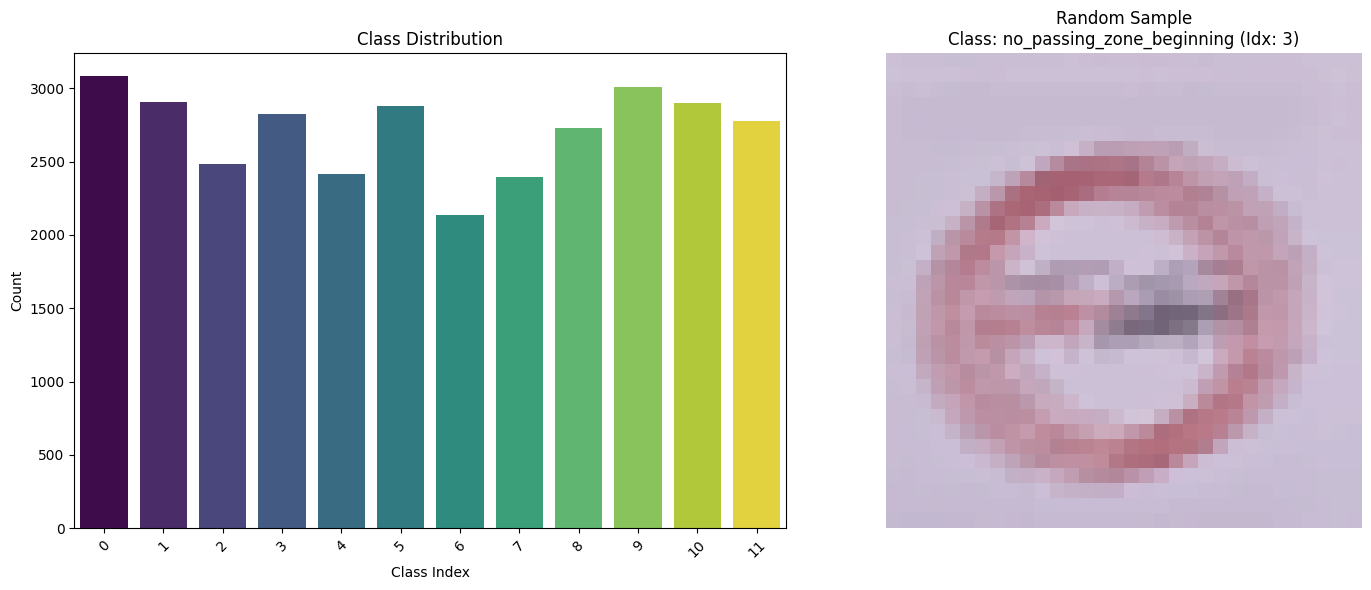

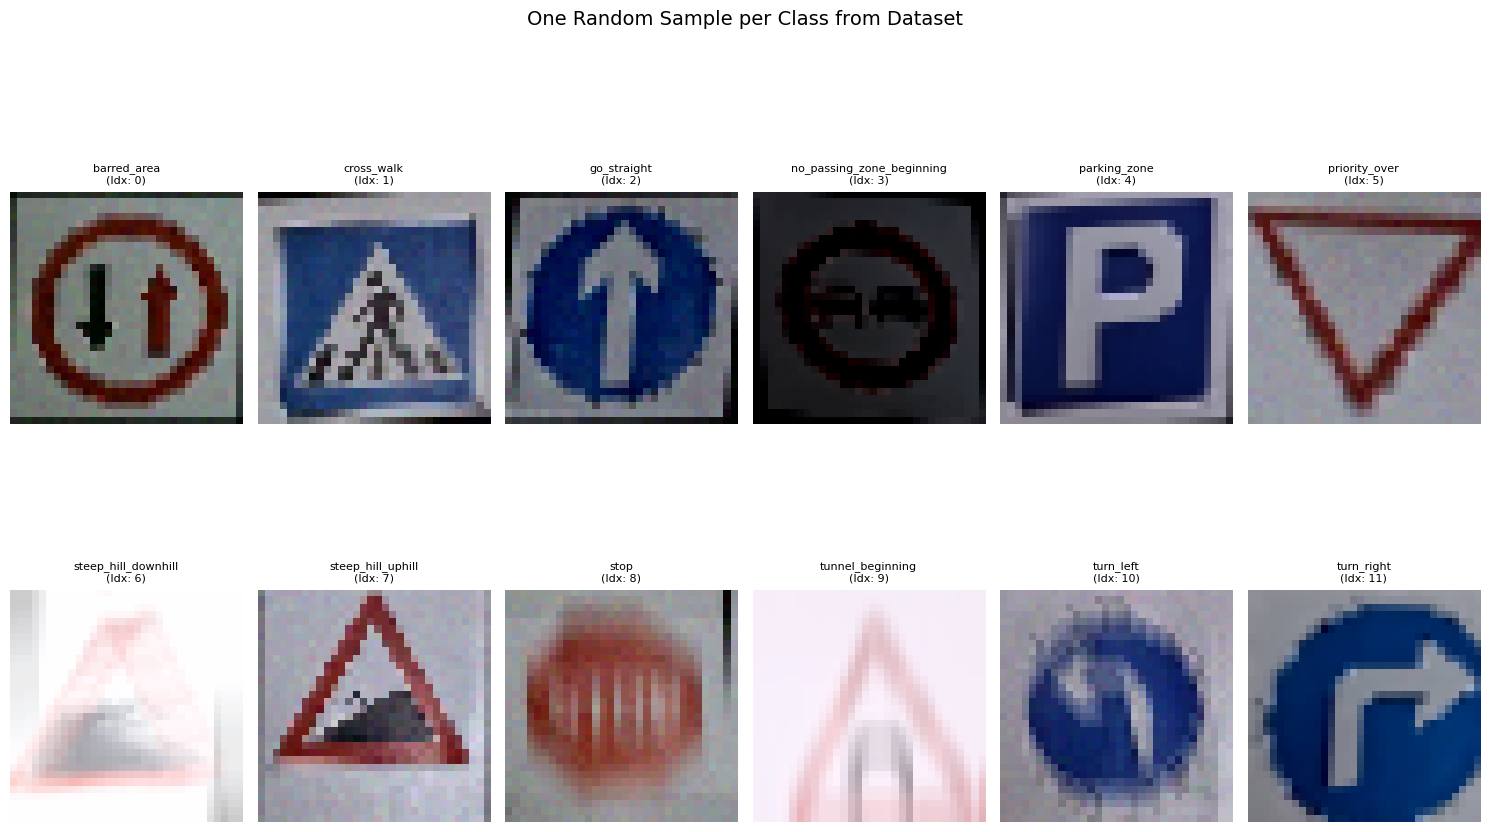

In [31]:
verify_dataset(train_dataset, class_names, mean=dataset_base_mean, std=dataset_base_std)


Class Distribution Details:
barred_area (Index 0): 617 samples
cross_walk (Index 1): 581 samples
go_straight (Index 2): 497 samples
no_passing_zone_beginning (Index 3): 565 samples
parking_zone (Index 4): 483 samples
priority_over (Index 5): 576 samples
steep_hill_downhill (Index 6): 427 samples
steep_hill_uphill (Index 7): 479 samples
stop (Index 8): 546 samples
tunnel_beginning (Index 9): 602 samples
turn_left (Index 10): 580 samples
turn_right (Index 11): 555 samples

Class Distribution Summary:
Total samples: 6508
Number of classes: 12
Mean samples per class: 542.3
Std samples per class: 55.3


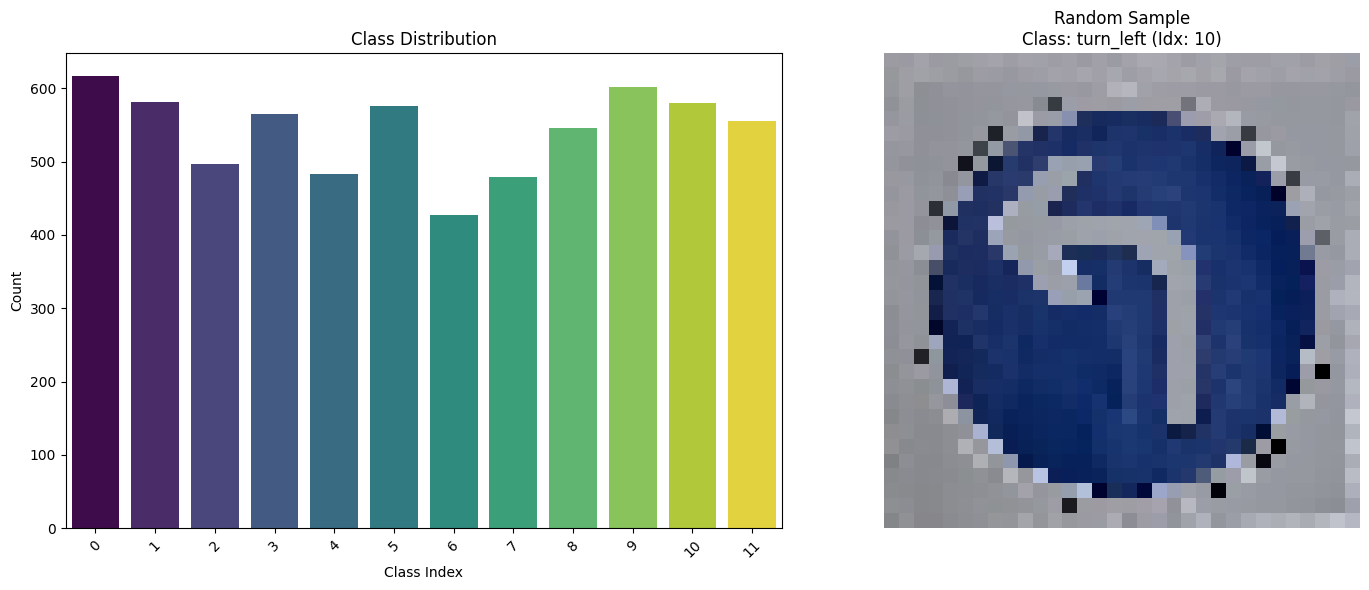

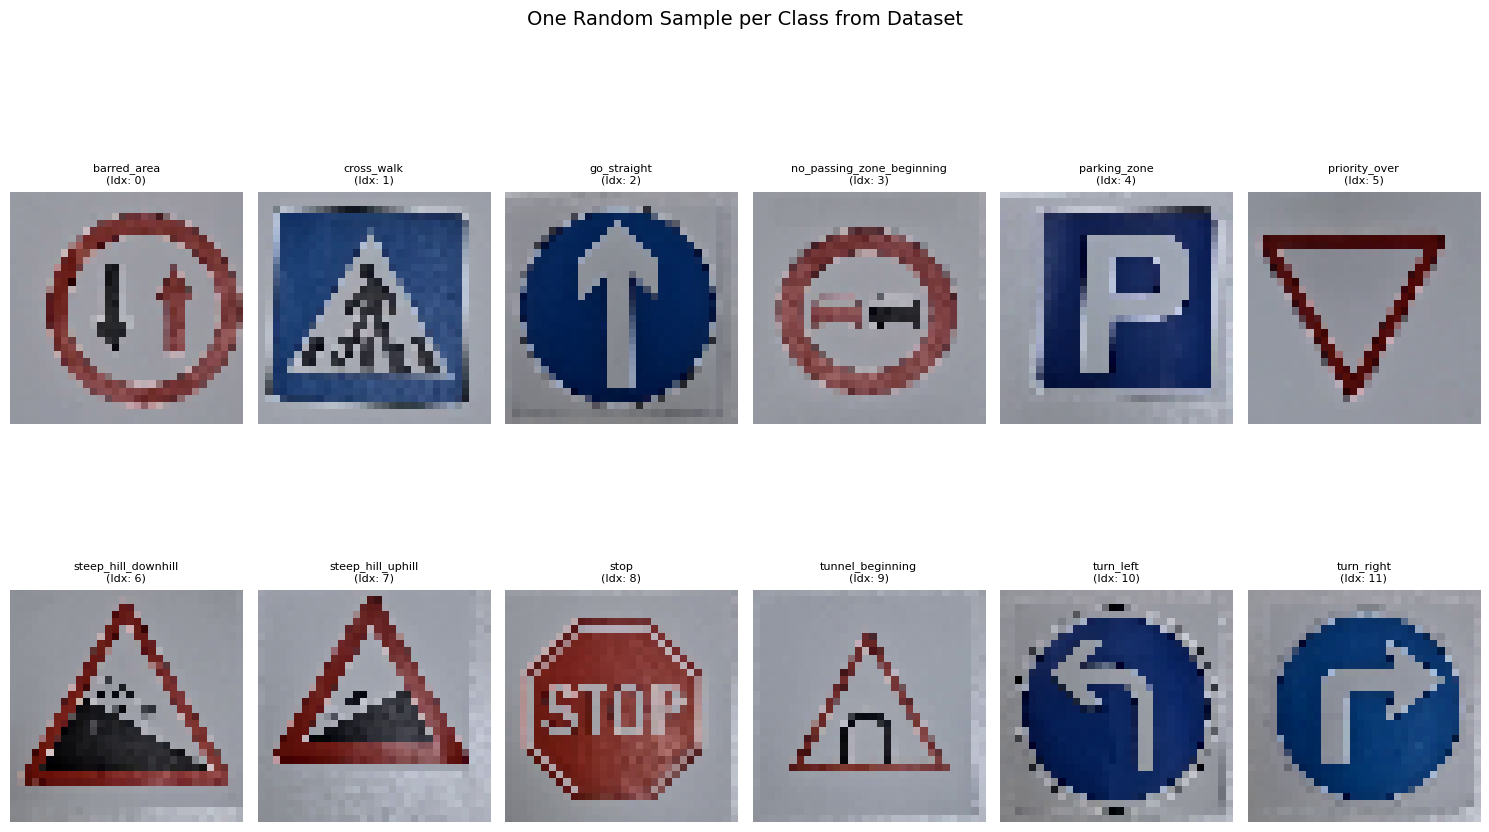

In [32]:
verify_dataset(test_dataset, class_names, mean=dataset_base_mean, std=dataset_base_std)


Class Distribution Details:
barred_area (Index 0): 428 samples
cross_walk (Index 1): 421 samples
go_straight (Index 2): 379 samples
no_passing_zone_beginning (Index 3): 434 samples
parking_zone (Index 4): 417 samples
priority_over (Index 5): 461 samples
steep_hill_downhill (Index 6): 360 samples
steep_hill_uphill (Index 7): 364 samples
stop (Index 8): 412 samples
tunnel_beginning (Index 9): 416 samples
turn_left (Index 10): 441 samples
turn_right (Index 11): 442 samples

Class Distribution Summary:
Total samples: 4975
Number of classes: 12
Mean samples per class: 414.6
Std samples per class: 30.3


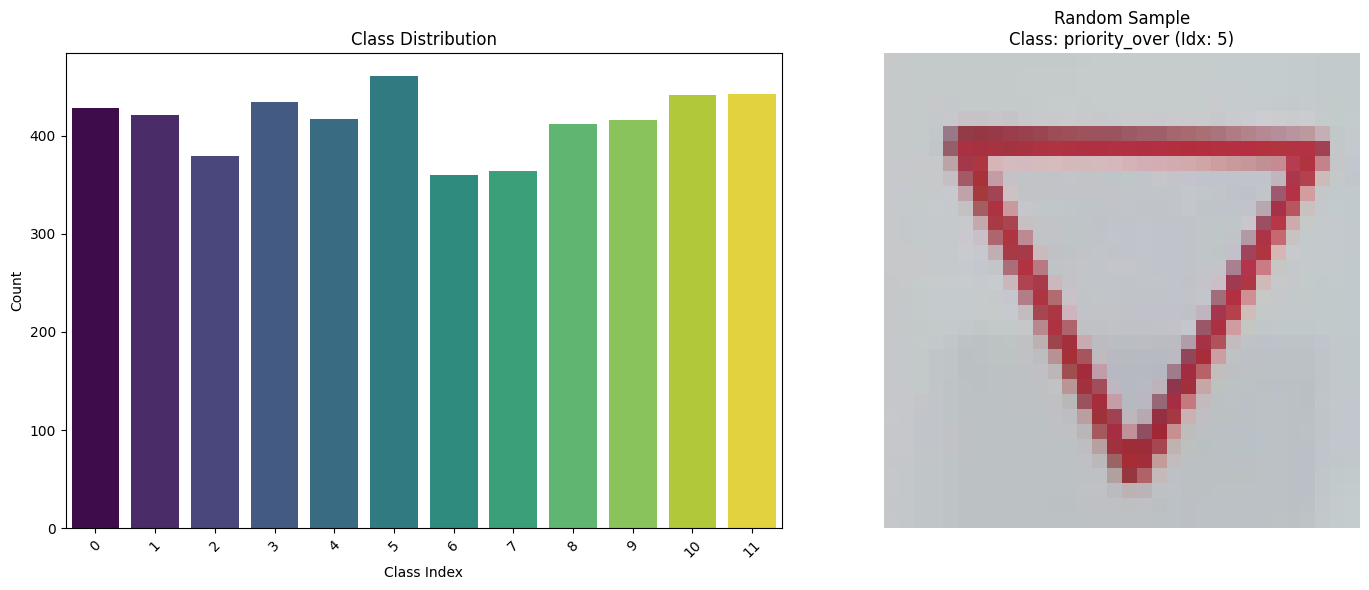

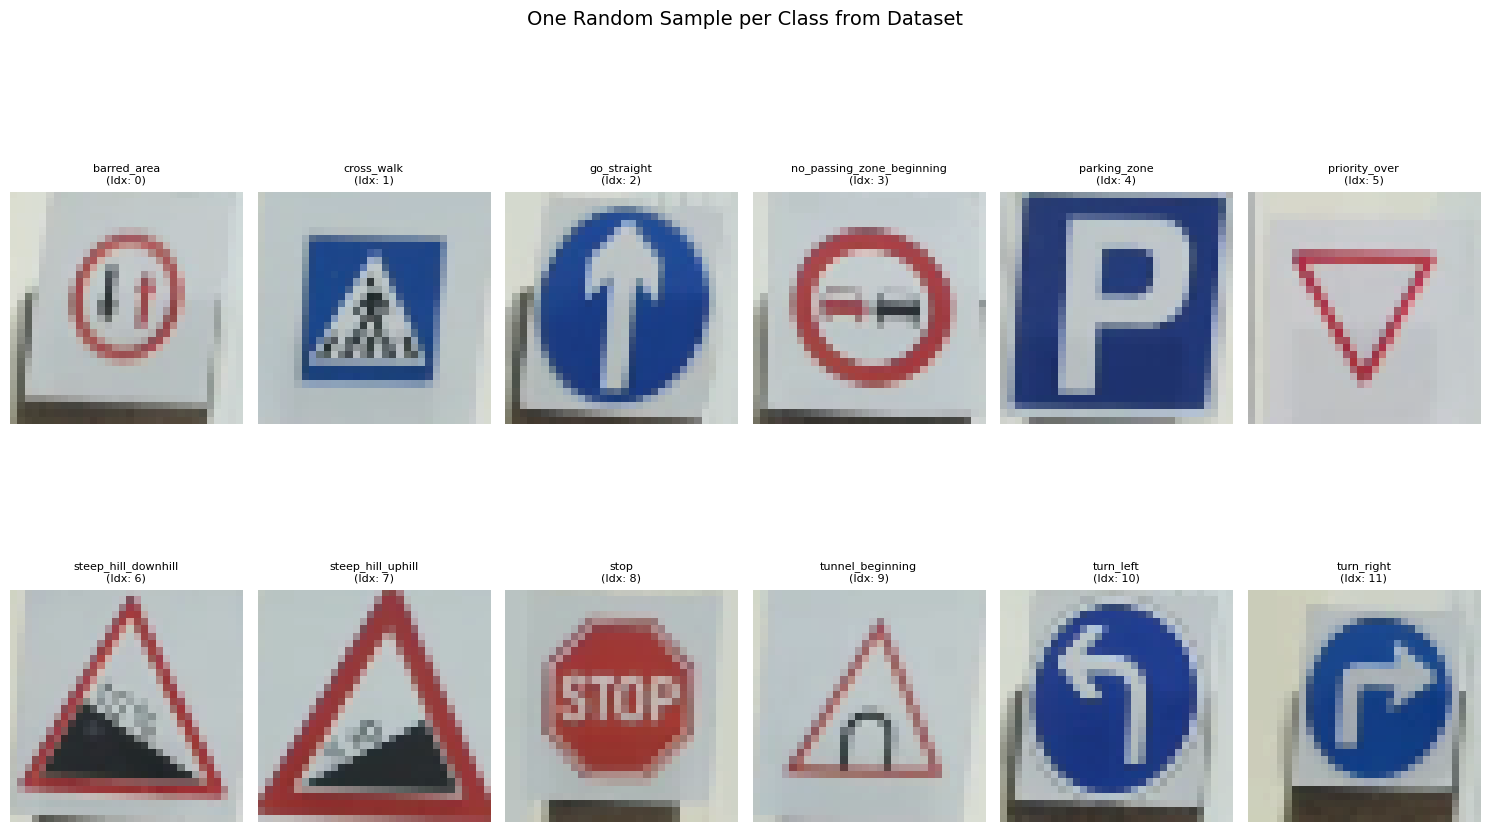

In [33]:
verify_dataset(val_dataset, class_names, mean=dataset_val_mean, std=dataset_val_std)

# Model

In [2]:
import os
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary
from tqdm import tqdm

### Dataloader

In [14]:
root_dir = r'Dataset'
root_dir_model = r'TrainedModels'

In [15]:
X_train = np.load(os.path.join(root_dir, 'X_train_data.npy'))
y_train = np.load(os.path.join(root_dir, 'y_train_labels.npy'))

X_test  = np.load(os.path.join(root_dir, 'X_test_data.npy'))
y_test  = np.load(os.path.join(root_dir, 'y_test_labels.npy'))

X_val  = np.load(os.path.join(root_dir, 'X_val_data.npy'))
y_val  = np.load(os.path.join(root_dir, 'y_val_labels.npy'))

In [16]:
y_train = np.argmax(y_train, axis=1)
y_test  = np.argmax(y_test, axis=1)
y_val  = np.argmax(y_val, axis=1)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).long()

X_test  = torch.from_numpy(X_test).float()
y_test  = torch.from_numpy(y_test).long()

X_val  = torch.from_numpy(X_val).float()
y_val  = torch.from_numpy(y_val).long()

In [17]:
train_dataset_Tensor = TensorDataset(X_train, y_train)
test_dataset_Tensor = TensorDataset(X_test, y_test)
val_dataset_Tensor = TensorDataset(X_val, y_val)

In [18]:
batch_size = 128

train_loader = DataLoader(
    dataset=train_dataset_Tensor,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
    )

test_loader  = DataLoader(
    dataset=test_dataset_Tensor,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
    )

val_loader  = DataLoader(
    dataset=val_dataset_Tensor,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
    )

### CNN Model

In [19]:
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=12):
        super(TrafficSignCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout(0.25)
        
        self.flatten_dim = 64 * 8 * 8
        self.fc1 = nn.Linear(self.flatten_dim, 256)
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        logits = self.fc2(x)
        
        return F.softmax(logits, dim=1)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = TrafficSignCNN(num_classes=12).to(device)
summary(model, input_size=(3, 32, 32))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='max',factor=0.1, patience=5, threshold=0.0001, threshold_mode='rel', cooldown=0, min_lr=0, eps=1e-8)

Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]           2,432
            Conv2d-2           [-1, 32, 32, 32]          25,632
         MaxPool2d-3           [-1, 32, 16, 16]               0
           Dropout-4           [-1, 32, 16, 16]               0
            Conv2d-5           [-1, 64, 16, 16]          18,496
            Conv2d-6           [-1, 64, 16, 16]          36,928
         MaxPool2d-7             [-1, 64, 8, 8]               0
           Dropout-8             [-1, 64, 8, 8]               0
            Linear-9                  [-1, 256]       1,048,832
          Dropout-10                  [-1, 256]               0
           Linear-11                   [-1, 12]           3,084
Total params: 1,135,404
Trainable params: 1,135,404
Non-trainable params: 0
----------------------------------------------------------------
Input s

### Training

In [21]:
def evaluate_model(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [22]:
epochs = 30
best_acc = 0.0

history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
print("Training the model...")
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    epoch_start = time.time()
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        
        pbar.set_postfix(loss=loss.item())
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    
    val_loss, val_acc = evaluate_model(model, val_loader, criterion, device)
    
    scheduler.step(val_acc)
    
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_acc)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_acc)
    
    for param_group in optimizer.param_groups:
        print(f"Current learning rate: {param_group['lr']}")
    
    if (val_acc > best_acc):
        best_acc = val_acc
        model_save_path = os.path.join(root_dir_model, 'traffic_sign_cnn_V05.pth')
        torch.save(model.state_dict(), model_save_path)
        print(f"Best model updated and saved with val_accuracy = {val_acc:.4f}")
        print(f"Current val_acc = {val_acc:.4f}, Best val_acc = {best_acc:.4f}")
    else:
        print(f"Model not improved. Best val_accuracy remains at {best_acc:.4f}")
    
    epoch_duration = time.time() - epoch_start
    remaining_time = (epochs - epoch - 1) * epoch_duration
    print(f"Epoch {epoch+1}/{epochs}: loss={epoch_loss:.4f}, accuracy={epoch_acc:.4f}, "
          f"val_loss={val_loss:.4f}, val_accuracy={val_acc:.4f}")
    print(f"Epoch time: {epoch_duration:.2f}s, estimated remaining: {remaining_time:.2f}s\n")
    
test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc * 100:.2f}%")

print("\nExporting model to ONNX format...")
try:
    example_input = torch.randn(1, 3, 32, 32).to(device)
    model.eval()
    torch.onnx.export(
        model, 
        (example_input,), 
        os.path.join(root_dir_model, 'traffic_sign_cnn_V05.onnx'),
        input_names=["input"],
        output_names=["output"],
        dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
        opset_version=13,
        verbose=False
    )
    print("Successfully exported ONNX model to:", os.path.join(root_dir_model, 'traffic_sign_cnn_V05.onnx'))
except Exception as e:
    print(f"Error exporting ONNX model: {e}")

model_save_path = os.path.join(root_dir_model, 'traffic_sign_cnn_V05_F.pth')
torch.save(model.state_dict(), model_save_path)
print("Saved PyTorch model to:", model_save_path)

history_df = pd.DataFrame(history)
history_save_path = os.path.join(root_dir_model, 'historyV05.csv')
history_df.to_csv(history_save_path, index=False)
print("Saved training history to:", history_save_path)

Training the model...


Epoch 1/30: 100%|██████████| 255/255 [00:06<00:00, 40.02batch/s, loss=1.62]


Current learning rate: 0.001
Best model updated and saved with val_accuracy = 0.8396
Current val_acc = 0.8396, Best val_acc = 0.8396
Epoch 1/30: loss=1.7723, accuracy=0.8491, val_loss=1.7779, val_accuracy=0.8396
Epoch time: 6.70s, estimated remaining: 194.31s



Epoch 2/30: 100%|██████████| 255/255 [00:05<00:00, 42.78batch/s, loss=1.62]


Current learning rate: 0.001
Best model updated and saved with val_accuracy = 0.8981
Current val_acc = 0.8981, Best val_acc = 0.8981
Epoch 2/30: loss=1.6527, accuracy=0.9666, val_loss=1.7201, val_accuracy=0.8981
Epoch time: 6.28s, estimated remaining: 175.93s



Epoch 3/30: 100%|██████████| 255/255 [00:05<00:00, 42.89batch/s, loss=1.68]


Current learning rate: 0.001
Model not improved. Best val_accuracy remains at 0.8981
Epoch 3/30: loss=1.6447, accuracy=0.9742, val_loss=1.7357, val_accuracy=0.8810
Epoch time: 6.26s, estimated remaining: 169.15s



Epoch 4/30: 100%|██████████| 255/255 [00:05<00:00, 42.82batch/s, loss=1.62]


Current learning rate: 0.001
Model not improved. Best val_accuracy remains at 0.8981
Epoch 4/30: loss=1.6417, accuracy=0.9776, val_loss=1.7224, val_accuracy=0.8951
Epoch time: 6.27s, estimated remaining: 163.09s



Epoch 5/30: 100%|██████████| 255/255 [00:05<00:00, 42.72batch/s, loss=1.62]


Current learning rate: 0.001
Model not improved. Best val_accuracy remains at 0.8981
Epoch 5/30: loss=1.6381, accuracy=0.9808, val_loss=1.7340, val_accuracy=0.8838
Epoch time: 6.29s, estimated remaining: 157.15s



Epoch 6/30: 100%|██████████| 255/255 [00:05<00:00, 42.83batch/s, loss=1.73]


Current learning rate: 0.001
Model not improved. Best val_accuracy remains at 0.8981
Epoch 6/30: loss=1.6397, accuracy=0.9789, val_loss=1.7618, val_accuracy=0.8569
Epoch time: 6.27s, estimated remaining: 150.46s



Epoch 7/30: 100%|██████████| 255/255 [00:05<00:00, 42.86batch/s, loss=1.65]


Current learning rate: 0.001
Model not improved. Best val_accuracy remains at 0.8981
Epoch 7/30: loss=1.6464, accuracy=0.9723, val_loss=1.7774, val_accuracy=0.8398
Epoch time: 6.27s, estimated remaining: 144.18s



Epoch 8/30: 100%|██████████| 255/255 [00:05<00:00, 42.69batch/s, loss=1.71]


Current learning rate: 0.0001
Model not improved. Best val_accuracy remains at 0.8981
Epoch 8/30: loss=1.6713, accuracy=0.9473, val_loss=1.7423, val_accuracy=0.8760
Epoch time: 6.29s, estimated remaining: 138.30s



Epoch 9/30: 100%|██████████| 255/255 [00:05<00:00, 42.86batch/s, loss=1.62]


Current learning rate: 0.0001
Model not improved. Best val_accuracy remains at 0.8981
Epoch 9/30: loss=1.6440, accuracy=0.9745, val_loss=1.7514, val_accuracy=0.8667
Epoch time: 6.27s, estimated remaining: 131.57s



Epoch 10/30: 100%|██████████| 255/255 [00:05<00:00, 42.93batch/s, loss=1.65]


Current learning rate: 0.0001
Model not improved. Best val_accuracy remains at 0.8981
Epoch 10/30: loss=1.6337, accuracy=0.9849, val_loss=1.7499, val_accuracy=0.8689
Epoch time: 6.25s, estimated remaining: 125.10s



Epoch 11/30: 100%|██████████| 255/255 [00:05<00:00, 42.99batch/s, loss=1.62]


Current learning rate: 0.0001
Model not improved. Best val_accuracy remains at 0.8981
Epoch 11/30: loss=1.6313, accuracy=0.9874, val_loss=1.7395, val_accuracy=0.8792
Epoch time: 6.24s, estimated remaining: 118.64s



Epoch 12/30: 100%|██████████| 255/255 [00:05<00:00, 43.05batch/s, loss=1.65]


Current learning rate: 0.0001
Model not improved. Best val_accuracy remains at 0.8981
Epoch 12/30: loss=1.6299, accuracy=0.9888, val_loss=1.7435, val_accuracy=0.8756
Epoch time: 6.24s, estimated remaining: 112.24s



Epoch 13/30: 100%|██████████| 255/255 [00:05<00:00, 43.13batch/s, loss=1.62]


Current learning rate: 0.0001
Model not improved. Best val_accuracy remains at 0.8981
Epoch 13/30: loss=1.6295, accuracy=0.9891, val_loss=1.7459, val_accuracy=0.8724
Epoch time: 6.23s, estimated remaining: 105.89s



Epoch 14/30: 100%|██████████| 255/255 [00:05<00:00, 43.04batch/s, loss=1.62]


Current learning rate: 1e-05
Model not improved. Best val_accuracy remains at 0.8981
Epoch 14/30: loss=1.6276, accuracy=0.9912, val_loss=1.7294, val_accuracy=0.8894
Epoch time: 6.24s, estimated remaining: 99.84s



Epoch 15/30: 100%|██████████| 255/255 [00:05<00:00, 42.96batch/s, loss=1.65]


Current learning rate: 1e-05
Model not improved. Best val_accuracy remains at 0.8981
Epoch 15/30: loss=1.6272, accuracy=0.9916, val_loss=1.7314, val_accuracy=0.8870
Epoch time: 6.24s, estimated remaining: 93.67s



Epoch 16/30: 100%|██████████| 255/255 [00:05<00:00, 43.03batch/s, loss=1.66]


Current learning rate: 1e-05
Model not improved. Best val_accuracy remains at 0.8981
Epoch 16/30: loss=1.6272, accuracy=0.9915, val_loss=1.7331, val_accuracy=0.8856
Epoch time: 6.24s, estimated remaining: 87.35s



Epoch 17/30: 100%|██████████| 255/255 [00:05<00:00, 43.13batch/s, loss=1.65]


Current learning rate: 1e-05
Model not improved. Best val_accuracy remains at 0.8981
Epoch 17/30: loss=1.6271, accuracy=0.9916, val_loss=1.7334, val_accuracy=0.8848
Epoch time: 6.23s, estimated remaining: 81.00s



Epoch 18/30: 100%|██████████| 255/255 [00:05<00:00, 43.05batch/s, loss=1.62]


Current learning rate: 1e-05
Model not improved. Best val_accuracy remains at 0.8981
Epoch 18/30: loss=1.6276, accuracy=0.9911, val_loss=1.7324, val_accuracy=0.8860
Epoch time: 6.25s, estimated remaining: 75.00s



Epoch 19/30: 100%|██████████| 255/255 [00:05<00:00, 43.01batch/s, loss=1.62]


Current learning rate: 1e-05
Model not improved. Best val_accuracy remains at 0.8981
Epoch 19/30: loss=1.6276, accuracy=0.9913, val_loss=1.7334, val_accuracy=0.8850
Epoch time: 6.25s, estimated remaining: 68.71s



Epoch 20/30: 100%|██████████| 255/255 [00:05<00:00, 43.00batch/s, loss=1.62]


Current learning rate: 1.0000000000000002e-06
Model not improved. Best val_accuracy remains at 0.8981
Epoch 20/30: loss=1.6273, accuracy=0.9913, val_loss=1.7308, val_accuracy=0.8876
Epoch time: 6.25s, estimated remaining: 62.46s



Epoch 21/30: 100%|██████████| 255/255 [00:05<00:00, 43.12batch/s, loss=1.62]


Current learning rate: 1.0000000000000002e-06
Model not improved. Best val_accuracy remains at 0.8981
Epoch 21/30: loss=1.6270, accuracy=0.9917, val_loss=1.7308, val_accuracy=0.8878
Epoch time: 6.23s, estimated remaining: 56.05s



Epoch 22/30: 100%|██████████| 255/255 [00:05<00:00, 43.04batch/s, loss=1.62]


Current learning rate: 1.0000000000000002e-06
Model not improved. Best val_accuracy remains at 0.8981
Epoch 22/30: loss=1.6269, accuracy=0.9918, val_loss=1.7308, val_accuracy=0.8876
Epoch time: 6.24s, estimated remaining: 49.91s



Epoch 23/30: 100%|██████████| 255/255 [00:05<00:00, 42.92batch/s, loss=1.65]


Current learning rate: 1.0000000000000002e-06
Model not improved. Best val_accuracy remains at 0.8981
Epoch 23/30: loss=1.6266, accuracy=0.9922, val_loss=1.7309, val_accuracy=0.8874
Epoch time: 6.25s, estimated remaining: 43.78s



Epoch 24/30: 100%|██████████| 255/255 [00:05<00:00, 43.34batch/s, loss=1.62]


Current learning rate: 1.0000000000000002e-06
Model not improved. Best val_accuracy remains at 0.8981
Epoch 24/30: loss=1.6271, accuracy=0.9916, val_loss=1.7310, val_accuracy=0.8874
Epoch time: 6.20s, estimated remaining: 37.22s



Epoch 25/30: 100%|██████████| 255/255 [00:05<00:00, 42.95batch/s, loss=1.62]


Current learning rate: 1.0000000000000002e-06
Model not improved. Best val_accuracy remains at 0.8981
Epoch 25/30: loss=1.6270, accuracy=0.9917, val_loss=1.7311, val_accuracy=0.8872
Epoch time: 6.25s, estimated remaining: 31.27s



Epoch 26/30: 100%|██████████| 255/255 [00:05<00:00, 42.96batch/s, loss=1.65]


Current learning rate: 1.0000000000000002e-07
Model not improved. Best val_accuracy remains at 0.8981
Epoch 26/30: loss=1.6271, accuracy=0.9915, val_loss=1.7311, val_accuracy=0.8870
Epoch time: 6.25s, estimated remaining: 25.01s



Epoch 27/30: 100%|██████████| 255/255 [00:05<00:00, 43.01batch/s, loss=1.65]


Current learning rate: 1.0000000000000002e-07
Model not improved. Best val_accuracy remains at 0.8981
Epoch 27/30: loss=1.6272, accuracy=0.9915, val_loss=1.7311, val_accuracy=0.8874
Epoch time: 6.25s, estimated remaining: 18.75s



Epoch 28/30: 100%|██████████| 255/255 [00:05<00:00, 43.12batch/s, loss=1.65]


Current learning rate: 1.0000000000000002e-07
Model not improved. Best val_accuracy remains at 0.8981
Epoch 28/30: loss=1.6264, accuracy=0.9923, val_loss=1.7311, val_accuracy=0.8872
Epoch time: 6.23s, estimated remaining: 12.46s



Epoch 29/30: 100%|██████████| 255/255 [00:05<00:00, 43.08batch/s, loss=1.62]


Current learning rate: 1.0000000000000002e-07
Model not improved. Best val_accuracy remains at 0.8981
Epoch 29/30: loss=1.6265, accuracy=0.9923, val_loss=1.7311, val_accuracy=0.8872
Epoch time: 6.24s, estimated remaining: 6.24s



Epoch 30/30: 100%|██████████| 255/255 [00:05<00:00, 43.17batch/s, loss=1.62]


Current learning rate: 1.0000000000000002e-07
Model not improved. Best val_accuracy remains at 0.8981
Epoch 30/30: loss=1.6268, accuracy=0.9919, val_loss=1.7311, val_accuracy=0.8872
Epoch time: 6.22s, estimated remaining: 0.00s

Test Loss: 1.6187, Test Accuracy: 100.00%

Exporting model to ONNX format...
Successfully exported ONNX model to: TrainedModels\traffic_sign_cnn_V05.onnx
Saved PyTorch model to: TrainedModels\traffic_sign_cnn_V05_F.pth
Saved training history to: TrainedModels\historyV05.csv


# Eval

In [23]:
def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    avg_loss = running_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

----------- Starting Model Evaluation -----------
Loading preprocessed test data...
Loading model...
Evaluating model on test data...
Test Loss: 1.6189, Test Accuracy: 99.98%
Loading training history...


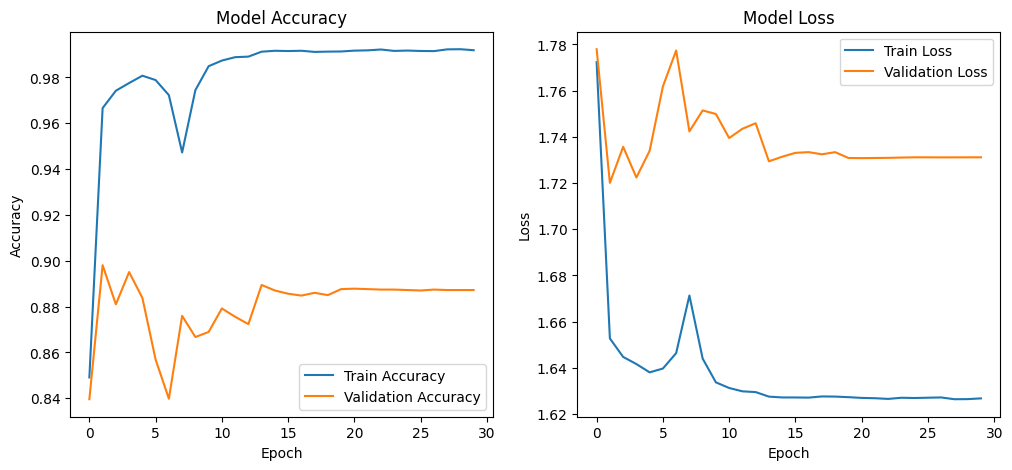

----------- Model Evaluation Complete -----------


In [24]:
root_dir = r'Dataset'
root_dir_model = r'TrainedModels'
batch_size = 64

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

print("----------- Starting Model Evaluation -----------")
print("Loading preprocessed test data...")

X_test = np.load(os.path.join(root_dir, 'X_test_data.npy'))
y_test = np.load(os.path.join(root_dir, 'y_test_labels.npy'))

y_test = np.argmax(y_test, axis=1)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Loading model...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TrafficSignCNN(num_classes=12).to(device)
model_path = os.path.join(root_dir_model, 'traffic_sign_cnn_V05.pth')
model.load_state_dict(torch.load(model_path, map_location=device))

criterion = nn.CrossEntropyLoss()

print("Evaluating model on test data...")
test_loss, test_acc = evaluate_model(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc * 100:.2f}%")

history_path = os.path.join(root_dir_model, 'historyV05.csv')
if os.path.exists(history_path):
    print("Loading training history...")
    history_df = pd.read_csv(history_path)
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_df['accuracy'], label='Train Accuracy')
    plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history_df['loss'], label='Train Loss')
    plt.plot(history_df['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

print("----------- Model Evaluation Complete -----------")

In [25]:
def predict_sample(model, image):
    model.eval()
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        prob = F.softmax(output, dim=1)
        pred = torch.argmax(prob, dim=1).item()
    return pred, prob.cpu().numpy()

print("\nSample validation predictions:")
num_samples = 10
indices = np.random.choice(len(val_dataset_Tensor), num_samples, replace=False)
for idx in indices:
    img, label = val_dataset_Tensor[idx]
    pred, prob = predict_sample(model, img)
    print(f"Sample index {idx}: Ground truth: {label.item()}, Prediction: {pred}")



Sample validation predictions:
Sample index 846: Ground truth: 1, Prediction: 1
Sample index 3947: Ground truth: 9, Prediction: 9
Sample index 2041: Ground truth: 4, Prediction: 4
Sample index 1416: Ground truth: 3, Prediction: 0
Sample index 241: Ground truth: 0, Prediction: 0
Sample index 2541: Ground truth: 6, Prediction: 6
Sample index 2174: Ground truth: 5, Prediction: 5
Sample index 3529: Ground truth: 8, Prediction: 8
Sample index 2507: Ground truth: 5, Prediction: 5
Sample index 2098: Ground truth: 5, Prediction: 5


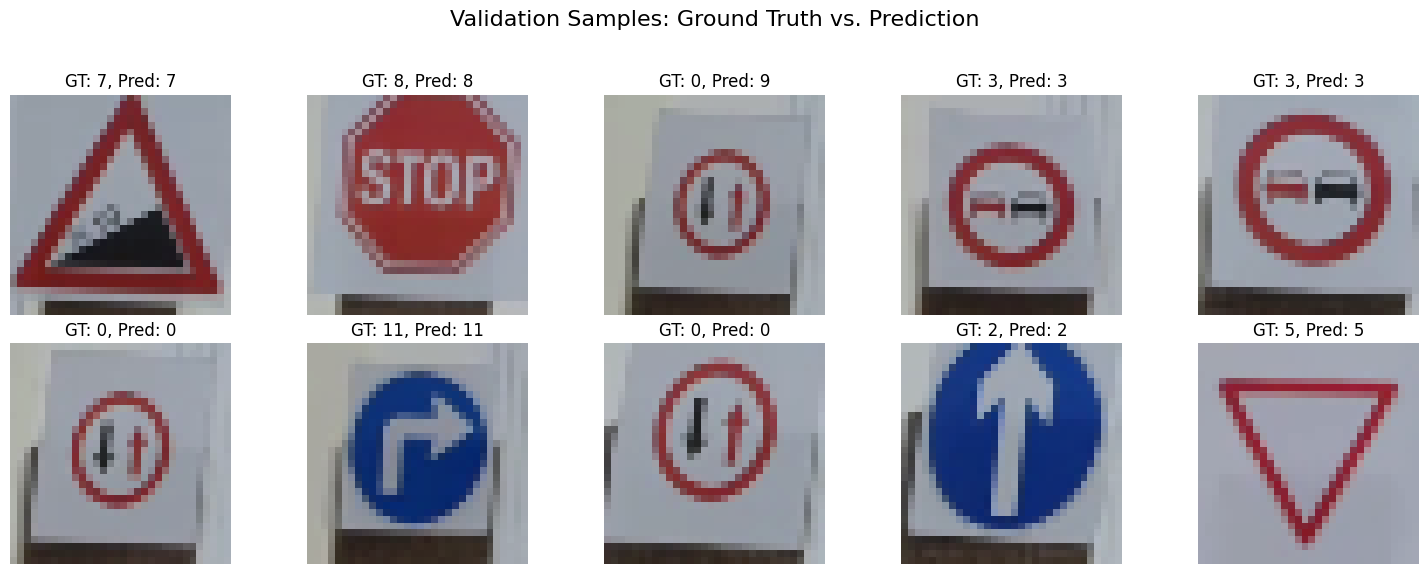

In [26]:
def denormalize_image(image_tensor, mean, std):
    image = image_tensor.cpu().numpy().transpose(1, 2, 0)
    mean = np.array(mean)
    std = np.array(std)
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return image

dataset_mean = [0.48011, 0.47254, 0.52592]
dataset_std  = [0.20765, 0.21533, 0.20043]

plt.figure(figsize=(15, 6))
for i, idx in enumerate(np.random.choice(len(val_dataset_Tensor), 10, replace=False)):
    img, label = val_dataset_Tensor[idx]
    pred, _ = predict_sample(model, img)
    img_disp = denormalize_image(img, dataset_mean, dataset_std)
    plt.subplot(2, 5, i+1)
    plt.imshow(img_disp)
    plt.title(f"GT: {label.item()}, Pred: {pred}")
    plt.axis("off")
plt.suptitle("Validation Samples: Ground Truth vs. Prediction", fontsize=16)
plt.tight_layout(rect=(0, 0.03, 1, 0.95))
plt.show()

In [ ]:
# from torchcam.methods import GradCAM

# cam_extractor = GradCAM(model)
# with cam_extractor as extractor:
#     out = model(input_tensor)
#     activation_map = extractor(out.squeeze(0).argmax().item(), out)

# plt.imshow(activation_map[0].squeeze().numpy(), cmap='jet')
# plt.title("Feature Activation Map")
# plt.show()